# Model 2
Here we will explore multiple models and to make compact our code we will first define some functions.

## Dataset

In [1]:
import json
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [2]:
from EEGDataset import EEGDataset
# Dataset object

eeg_dataset = EEGDataset('SynapSee_data.json', subjects_to_include='mateo')
len(eeg_dataset)

1160

In [3]:
def stratified_split(dataset,
                      stratify_by,
                      test_size=0.2, 
                      random_state=420, 
                      print_distributions=False):
    """
    Splits a dataset into training and validation subsets while preserving the class distribution.

    Args:
        dataset (Dataset): The dataset to split.
        stratify_by (str): The name of the attribute to stratify by.
        test_size (float): The proportion of the dataset to include in the validation set.
        random_state (int): The random seed to use for reproducible results.
        print_distributions (bool): Whether to print the class distributions in each subset.

    Returns:
        (Dataset, Dataset): A tuple containing the training and validation subsets.
    """
    # Get the indices corresponding to each class
    labels = [item[stratify_by] for item in dataset.data]

    # Split the dataset into training and validation sets while preserving the class distribution
    train_idx, val_idx = train_test_split(
        range(len(dataset)), 
        test_size=test_size, 
        stratify=labels,
        random_state=random_state)
    
    # Create the subsets
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    if print_distributions:
        def count_classes(dataset):
            """ Count the occurrences of each class in the dataset. """
            class_counts = {}
            for item in dataset:
                label = item['class']
                if label in class_counts:
                    class_counts[label] += 1
                else:
                    class_counts[label] = 1
            return class_counts

        # Count classes in each subset
        train_class_counts = count_classes(train_subset)
        val_class_counts = count_classes(val_subset)

        # print counts
        print("Training set class counts:", train_class_counts)
        print("Validation set class counts:", val_class_counts)

        # print percentages
        print("Training set class percentages:")
        for label, count in train_class_counts.items():
            print(f"{label}: {count / len(train_subset):.1%}")
        print("Validation set class percentages:")
        for label, count in val_class_counts.items():
            print(f"{label}: {count / len(val_subset):.1%}")

    return train_subset, val_subset

# Split the dataset into training and validation subsets
train_dataset, val_dataset = stratified_split(eeg_dataset, 
                                              stratify_by='class', 
                                              random_state=420, 
                                              print_distributions=True)


Training set class counts: {2: 231, 3: 228, 0: 235, 1: 234}
Validation set class counts: {0: 58, 1: 59, 3: 57, 2: 58}
Training set class percentages:
2: 24.9%
3: 24.6%
0: 25.3%
1: 25.2%
Validation set class percentages:
0: 25.0%
1: 25.4%
3: 24.6%
2: 25.0%


In [4]:
batch_size = 15
# Create a DataLoader to load the training set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Create a DataLoader to load the validation set
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# training loop function
def train_model(model,
                  train_loader, 
                  val_loader,
                  criterion,
                  optimizer,
                  device,
                  num_epochs=50,
                  patience=-1,
                  verbose=False):
    """
    Trains a model and returns the training and validation losses and accuracies.

    Args:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): A DataLoader for the training set.
        val_loader (DataLoader): A DataLoader for the validation set.
        criterion (torch.nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        device (str): The device to run the training on.
        num_epochs (int): The number of epochs to train for.
        patience (int): The number of epochs to wait for the validation loss to improve before early stopping.
                default: -1 (no early stopping) (all negative values are treated as -1)
        verbose (int): Whether to print the training progress every `verbose` epochs.

    Returns:
        (list, list, list): A tuple of lists containing the training losses, validation losses, and validation accuracies.
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0 # total loss for the training set
        correct_train = 0 # total number of correct predictions in the training set
        total_train = 0 # total number of samples in the training set

        for batch in train_loader:
            eeg_signals = batch['eeg_signal'].to(device)
            targets = batch['class'].to(device)

            # Forward pass
            outputs = model(eeg_signals)
            loss = criterion(outputs, targets)

            # Backward and optimize
            # make gradients zero
            optimizer.zero_grad()
            # backpropagate
            loss.backward()
            # update parameters
            optimizer.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train


        # Validation phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_loader:
                eeg_signals = batch['eeg_signal'].to(device)
                targets = batch['class'].to(device)

                outputs = model(eeg_signals)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_val += targets.size(0)
                correct_val  += (predicted == targets).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if verbose and (epoch % verbose == 0 or epoch == num_epochs - 1):
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if epochs_no_improve == patience:
            print("Early stopping triggered")
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            break
        
    return train_losses, train_accuracies, val_losses, val_accuracies

# Example usage:
# train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, 
#                                                                           train_loader, 
#                                                                           val_loader,
#                                                                           criterion,
#                                                                           optimizer, 
#                                                                           device,
#                                                                           num_epochs=10,
#                                                                           patience=5)


In [6]:
def plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, grey_background=True):
    """
    Plots the training and validation losses and accuracies.

    Args:
        train_losses (list): A list of training losses.
        val_losses (list): A list of validation losses.
        val_accuracies (list): A list of validation accuracies.
    """
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plotting training and validation losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss', alpha=0.5)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    # Plotting training and validation accuracies
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy', alpha=0.5)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    if grey_background:
        # Set the background color of the figure
        fig.set_facecolor('grey')
        # Set the background color of the plot
        ax1.set_facecolor('grey')
        ax2.set_facecolor('grey')
        # set the label color
        ax1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, facecolor=(0.70, 0.70, 0.70))
        ax2.legend(fancybox=True, framealpha=1, shadow=False, borderpad=1, facecolor=(0.70, 0.70, 0.70))
    else:
        ax1.legend()
        ax2.legend()

    plt.show()

In [7]:
# plot confusion matrix and accuracy
def plot_metrics(true_labels, pred_labels, class_names, grey_background=True, size=(6, 6)):
    """
    Plots the confusion matrix and the accuracy for each class.

    :param true_labels: List or array of true labels
    :param pred_labels: List or array of predicted labels
    :param class_names: List of class names
    :param grey_background: Boolean, if True, set the background color to grey
    :param size: Tuple, the figure size
    """
    # Calculate the confusion matrix and class accuracies
    cm = confusion_matrix(true_labels, pred_labels)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=size)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    if grey_background:
        # https://colors-picker.com/hex-color-picker/
        blue = "#2196f3"  
        grey = "#192c4d"  
        custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_blue_grey", [blue, grey])
        # custom_cmap = sns.cubehelix_palette(start=2.8, rot=0.1, dark=0.5, light=0.8, 
        #                                     reverse=False, as_cmap=True)
        disp.plot(cmap=custom_cmap, ax=axes[0], xticks_rotation='vertical', colorbar=False)
    else:
        disp.plot(cmap='Blues', ax=axes[0], xticks_rotation='vertical', colorbar=False)

    axes[0].set_title('Confusion Matrix')

    # Plot accuracy for each class
    axes[1].bar(class_names, class_accuracies)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy for Each Class')
    axes[1].set_ylim([0, 1])

    # Set background color if grey_background is True
    if grey_background:
        fig.set_facecolor('grey')
        for ax in axes:
            ax.set_facecolor('grey')

    plt.tight_layout()
    plt.show()

def evaluate_class_metrics(model, 
                           data_loader, 
                           device, 
                           class_names, 
                           print_metrics=True, 
                           grey_background=True, 
                           size=(12, 6)):
    """
    Evaluates the model on the given DataLoader and calculates the accuracy for each class.
    Also prints total number of observations, count per class, correct counts per class, and overall accuracy.

    :param model: The trained model
    :param data_loader: DataLoader for the dataset to evaluate
    :param device: The device to run the model on ('cuda' or 'cpu')
    :param class_names: List of class names
    :param print_metrics: Boolean, if True, print the metrics
    :param grey_background: Boolean, if True, set the background color to grey in the plots
    :param size: Tuple, the size of the plot
    :return: None
    """
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    pred_labels = []
    class_counts = [0] * len(class_names)
    correct_class_counts = [0] * len(class_names)
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['eeg_signal'].to(device)
            labels = batch['class'].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            labels_cpu = labels.cpu().numpy()
            predicted_cpu = predicted.cpu().numpy()
            true_labels.extend(labels_cpu)
            pred_labels.extend(predicted_cpu)

            for label, prediction in zip(labels_cpu, predicted_cpu):
                class_counts[label] += 1
                if label == prediction:
                    correct_class_counts[label] += 1
                    correct_predictions += 1

    total_observations = len(true_labels)
    overall_accuracy = correct_predictions / total_observations

    if print_metrics:    
        print(f"Total correct predictions: {correct_predictions}/{total_observations}")
        print(f"Overall accuracy: {overall_accuracy:.4f}")
        for i, class_name in enumerate(class_names):
            print(f"Correct predictions for {class_name}: {correct_class_counts[i]}/{class_counts[i]}; Accuracy: {correct_class_counts[i] / class_counts[i]:.4f}")

    # Calculate and plot accuracies
    plot_metrics(true_labels, pred_labels, class_names, grey_background=grey_background, size=size)


In [8]:
# Might delete this later
def count_classes_in_dataloader(dataloader):
    """ Count the occurrences of each class in the dataloader. """
    class_counts = {}
    for batch in dataloader:
        for item in batch['class']:
            label = item.item()
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1
    return class_counts

## Models

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [10]:
class EEGConv(nn.Module):
    def __init__(self, num_classes=4):
        super(EEGConv, self).__init__()
        
        input_channels = 16  # Adjust this if the number of channels is different
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3)

        # Assume some flattening and reduction happen after convolution
        # The number 123 - 2 is based on the convolution operation without padding
        conv_output_size = (123 - 2) * 64  

        # First fully connected layer
        self.fc1 = nn.Linear(conv_output_size, 128)  # 128 is an example size

        # Second fully connected layer
        self.fc2 = nn.Linear(128, 64)  # 64 is an example size

        # Final classifier layer
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):

        # N is the batch size
        # C is the number of channels
        # L is the length of the signal sequence

        # EEG signal shape: torch.Size([10, 123, 16])
        # N: 10 is the batch size
        # L: 123 is the length of the signal sequence
        # C: 16 is the number of channels

        # Since we need to match the input to (N, C, L) format expected by nn.Conv1d,
        # we need to transpose the input
        x = x.transpose(1, 2)  # Transpose the 2nd and 3rd dimension

        # Apply the first convolutional layer
        x = F.relu(self.conv1(x))

        # Flatten the output for the fully connected layers
        # x.view() is similar to numpy.reshape()
        # The -1 is a placeholder for an inferred dimension
        x = x.view(x.size(0), -1)

        # Apply the first fully connected layer
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer
        x = F.relu(self.fc2(x))

        # Apply the classifier
        x = self.fc3(x)


        return x

# Example usage
# model = EEGNet(num_classes=4)
# output = model(eeg_signal)  # eeg_signal should be a batch from your DataLoader


Epoch [1/1000], Train Loss: 154.1023, Train Accuracy: 0.2726, Validation Loss: 22.9172, Validation Accuracy: 0.3060
Epoch [11/1000], Train Loss: 31.0366, Train Accuracy: 0.2985, Validation Loss: 53.7616, Validation Accuracy: 0.2888
Epoch [21/1000], Train Loss: 35.1579, Train Accuracy: 0.2931, Validation Loss: 77.2315, Validation Accuracy: 0.2888
Epoch [31/1000], Train Loss: 29.0811, Train Accuracy: 0.3610, Validation Loss: 47.4938, Validation Accuracy: 0.3362
Epoch [41/1000], Train Loss: 25.2432, Train Accuracy: 0.3610, Validation Loss: 29.4580, Validation Accuracy: 0.3448
Early stopping triggered
Epoch [42/1000], Train Loss: 29.2474, Train Accuracy: 0.3362, Validation Loss: 26.7879, Validation Accuracy: 0.3276


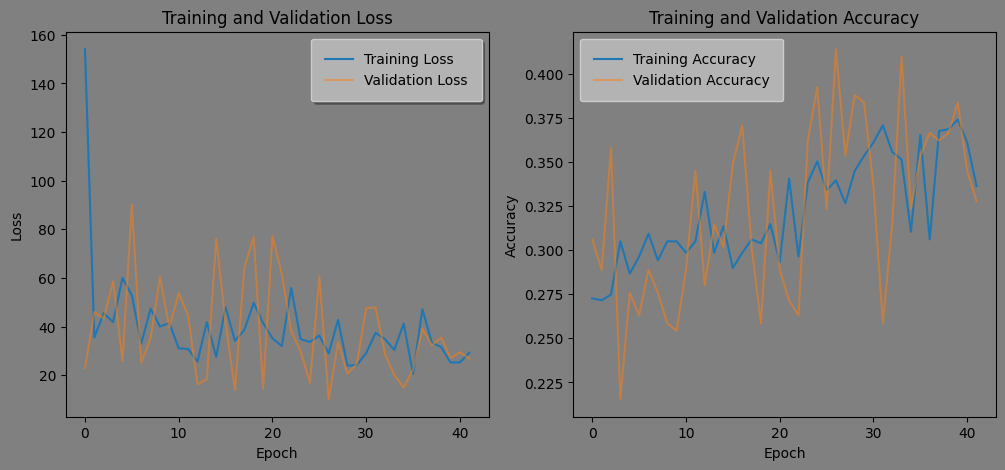

Total correct predictions: 309/928
Overall accuracy: 0.3330
Correct predictions for cat: 235/235; Accuracy: 1.0000
Correct predictions for dog: 72/234; Accuracy: 0.3077
Correct predictions for rabbit: 0/231; Accuracy: 0.0000
Correct predictions for control: 2/228; Accuracy: 0.0088


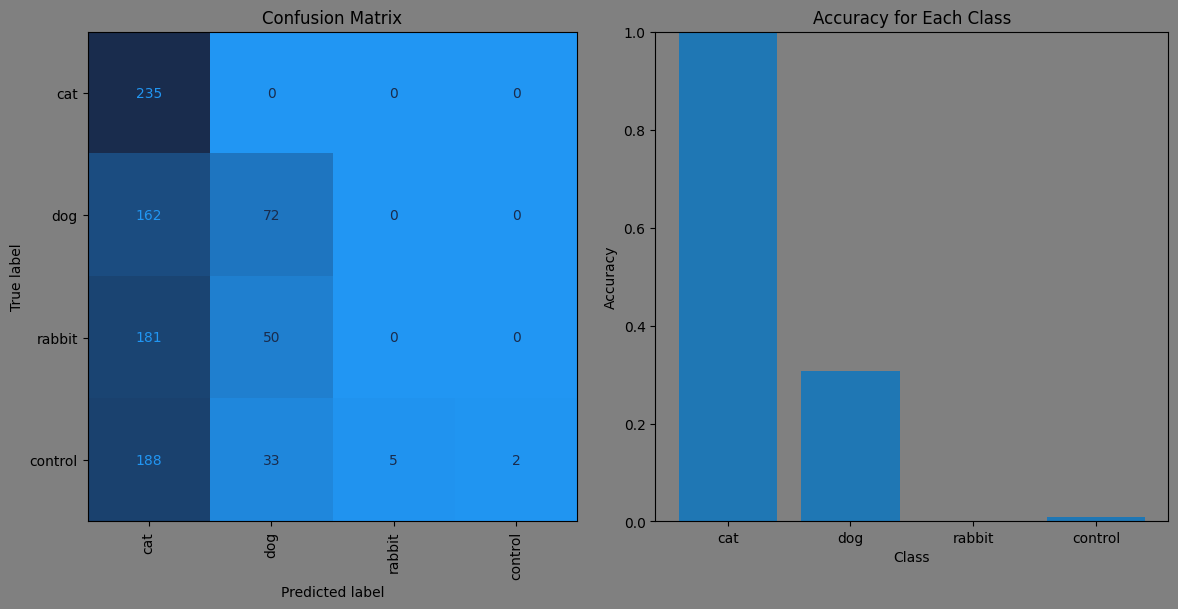

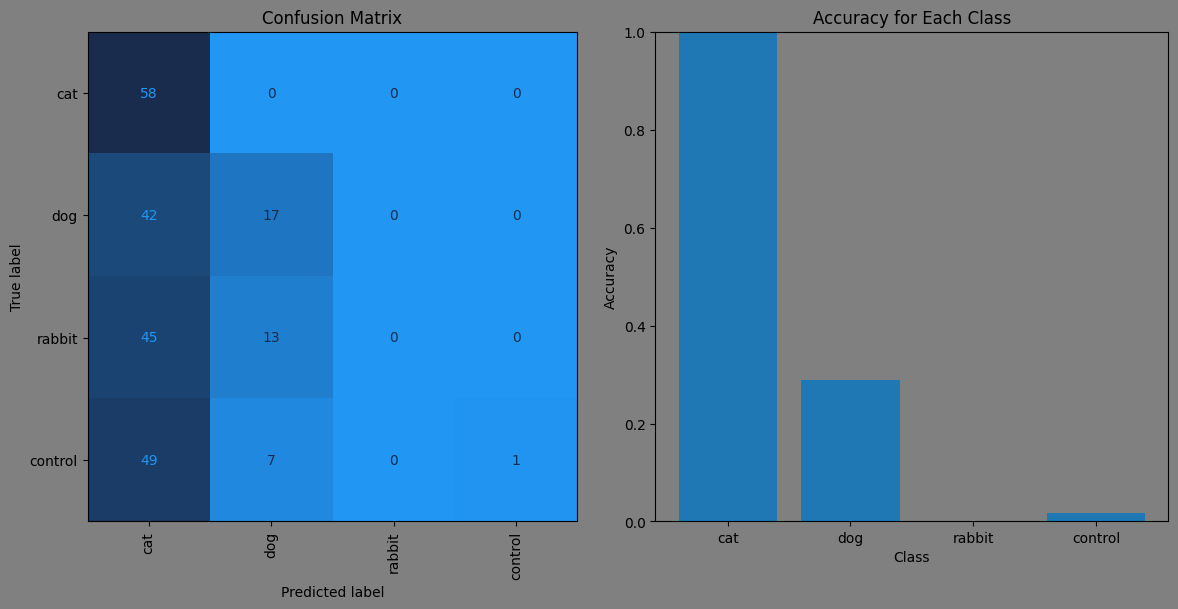

In [11]:
eegconv = EEGConv(num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(eegconv.parameters(), lr=0.00001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(eegconv, 
                                                                        train_dataloader, 
                                                                        val_dataloader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=1000, 
                                                                        patience=15, 
                                                                        verbose=10)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(eegconv, train_dataloader, device,
                       class_names=eeg_dataset.class_mapping.keys())

# Evaluate the model on the validation set
evaluate_class_metrics(eegconv, val_dataloader, device, print_metrics=False,
                       class_names=eeg_dataset.class_mapping.keys())

In [16]:
import torch
import torch.nn as nn

class EEGLSTM(nn.Module):
    """
    A class for an LSTM model for EEG classification.

    Attributes:
        hidden_size (int): The number of features in the hidden state h.
        num_layers (int): The number of recurrent layers.
        num_classes (int): The number of classes in the dataset.

    Args:
        input_size (int): The number of expected features in the input x.
        hidden_size (int): The number of features in the hidden state h.
        num_layers (int): The number of layers in the lstm.
        num_classes (int): The number of classes in the dataset.
    """             
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EEGLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 128)  # Example size
        self.fc2 = nn.Linear(128, 64)          # Example size

        # Classifier
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Initialize hidden state (short-term memory) and cell state (long-term memory)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate through the LSTM layer
        # x needs to be of the shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x, (h0, c0))

        # Get the output from the last time step
        out = out[:, -1, :]

        # Forward propagate through the fully connected layers
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))

        # Classifier
        out = self.fc3(out)

        return out



Epoch [1/2000], Train Loss: 26.2886, Train Accuracy: 0.3330, Validation Loss: 26.8397, Validation Accuracy: 0.3276
Epoch [11/2000], Train Loss: 26.3025, Train Accuracy: 0.3330, Validation Loss: 26.4408, Validation Accuracy: 0.3276
Early stopping triggered
Epoch [20/2000], Train Loss: 26.3519, Train Accuracy: 0.3330, Validation Loss: 28.0135, Validation Accuracy: 0.3276


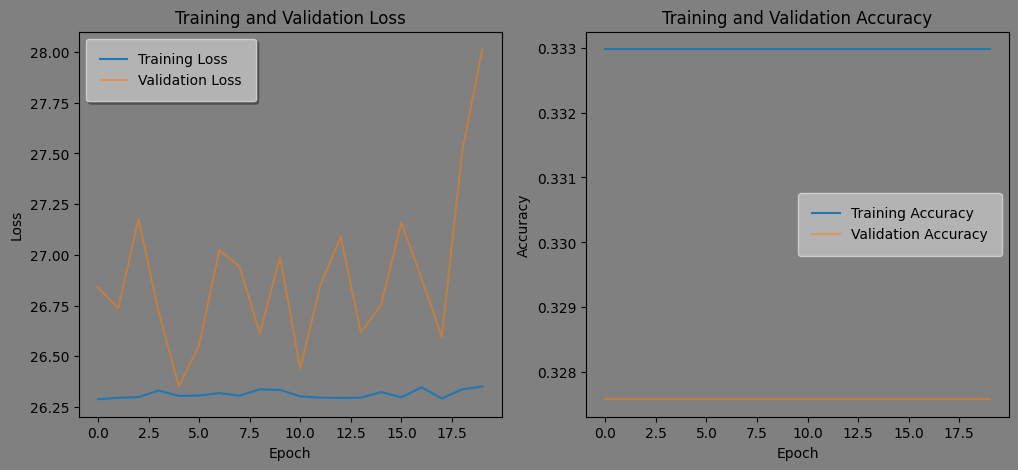

Total correct predictions: 234/928
Overall accuracy: 0.2522
Correct predictions for cat: 0/235; Accuracy: 0.0000
Correct predictions for dog: 234/234; Accuracy: 1.0000
Correct predictions for rabbit: 0/231; Accuracy: 0.0000
Correct predictions for control: 0/228; Accuracy: 0.0000


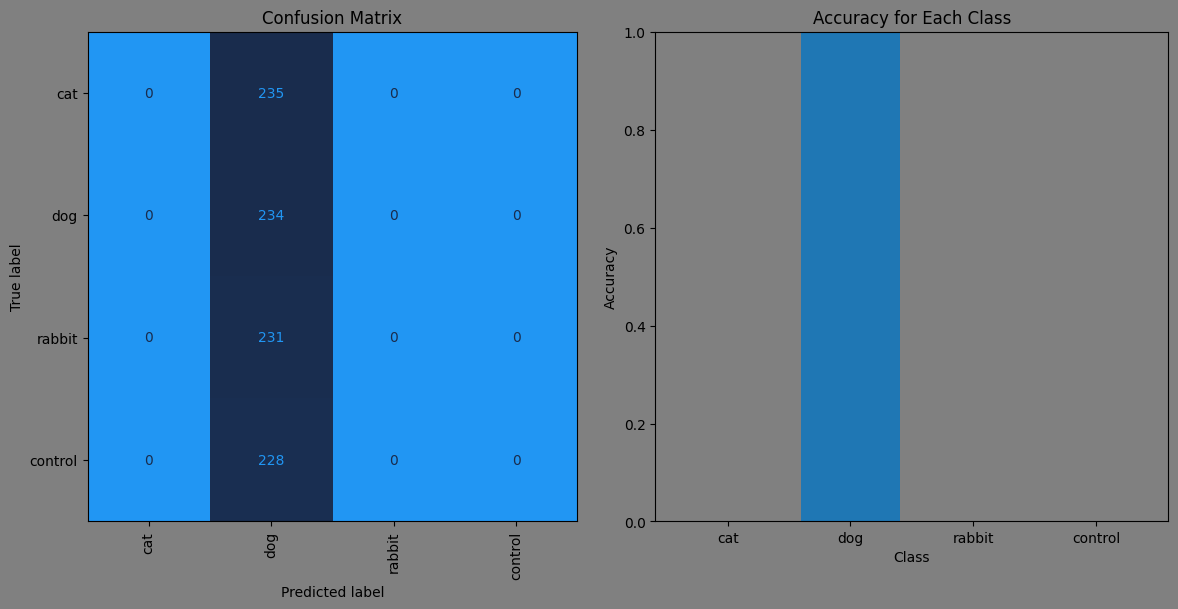

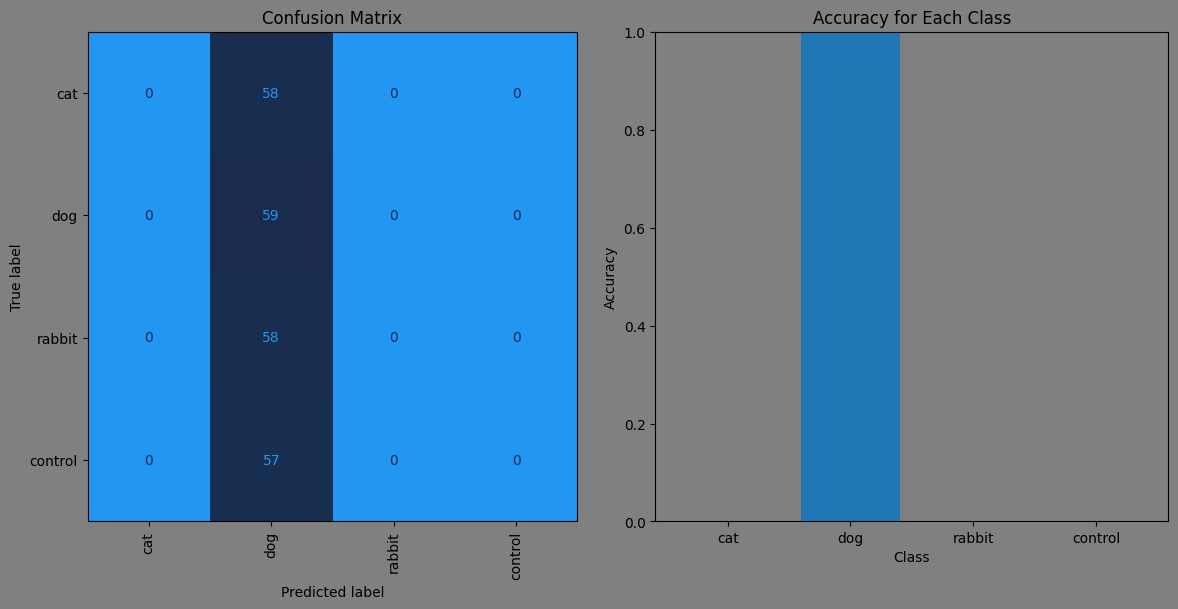

In [17]:

eeglstm = EEGLSTM(input_size=16, hidden_size=50, num_layers=2, num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(eeglstm.parameters(), lr=0.00001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(eegconv, 
                                                                        train_dataloader, 
                                                                        val_dataloader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=2000, 
                                                                        patience=15, 
                                                                        verbose=10)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(eeglstm, train_dataloader, device,
                        class_names=eeg_dataset.class_mapping.keys())

# Evaluate the model on the validation set
evaluate_class_metrics(eeglstm, val_dataloader, device, print_metrics=False,
                        class_names=eeg_dataset.class_mapping.keys())

In [20]:
class EEGSuperConv(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(EEGSuperConv, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        # Adaptive pooling to make it size-independent
        self.adap_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        
        # transpose the input to match the expected format
        x = x.transpose(1, 2)
        
        # Applying convolutional layers with ReLU activations and pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool1d(x, 2)

        # Adaptive pooling and flattening
        x = self.adap_pool(x)
        x = torch.flatten(x, 1)

        # Fully connected layer for classification
        x = self.fc(x)

        return x

Epoch [1/2000], Train Loss: 74.4719, Train Accuracy: 0.2575, Validation Loss: 29.6951, Validation Accuracy: 0.1897
Epoch [101/2000], Train Loss: 0.4745, Train Accuracy: 0.8254, Validation Loss: 0.4026, Validation Accuracy: 0.8491
Epoch [201/2000], Train Loss: 0.4425, Train Accuracy: 0.8481, Validation Loss: 1.2941, Validation Accuracy: 0.7112
Epoch [301/2000], Train Loss: 0.6816, Train Accuracy: 0.8060, Validation Loss: 0.7161, Validation Accuracy: 0.8060
Epoch [401/2000], Train Loss: 0.5051, Train Accuracy: 0.8297, Validation Loss: 0.3445, Validation Accuracy: 0.8534
Epoch [501/2000], Train Loss: 0.5027, Train Accuracy: 0.8578, Validation Loss: 0.5390, Validation Accuracy: 0.8362
Epoch [601/2000], Train Loss: 0.4961, Train Accuracy: 0.8513, Validation Loss: 0.4993, Validation Accuracy: 0.8448
Epoch [701/2000], Train Loss: 0.3101, Train Accuracy: 0.8955, Validation Loss: 0.3297, Validation Accuracy: 0.8879
Epoch [801/2000], Train Loss: 0.4325, Train Accuracy: 0.8782, Validation Loss: 0

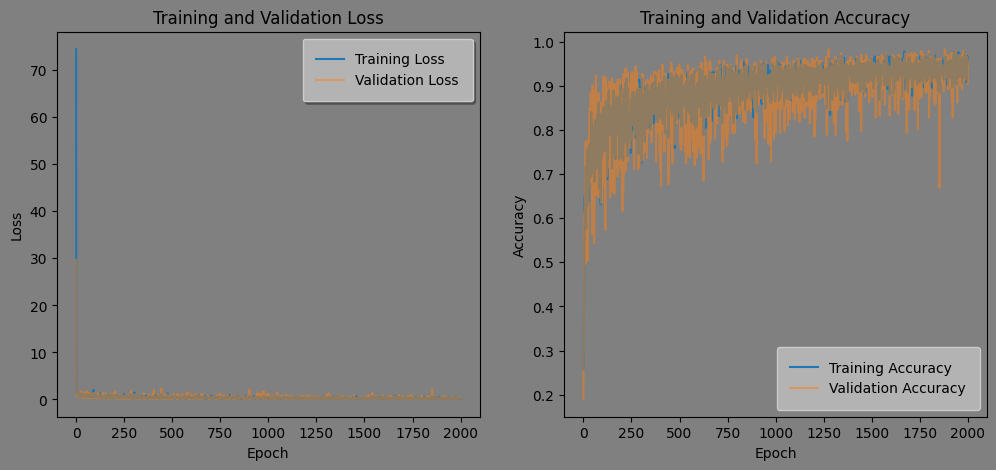

Total correct predictions: 871/928
Overall accuracy: 0.9386
Correct predictions for cat: 203/235; Accuracy: 0.8638
Correct predictions for dog: 234/234; Accuracy: 1.0000
Correct predictions for rabbit: 220/231; Accuracy: 0.9524
Correct predictions for control: 214/228; Accuracy: 0.9386


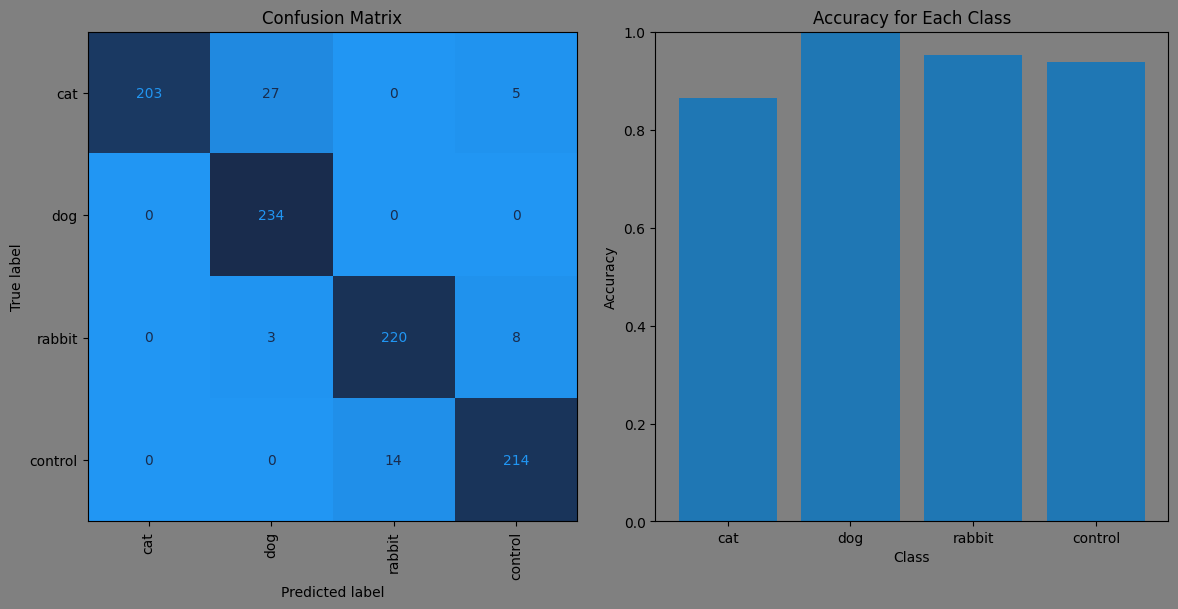

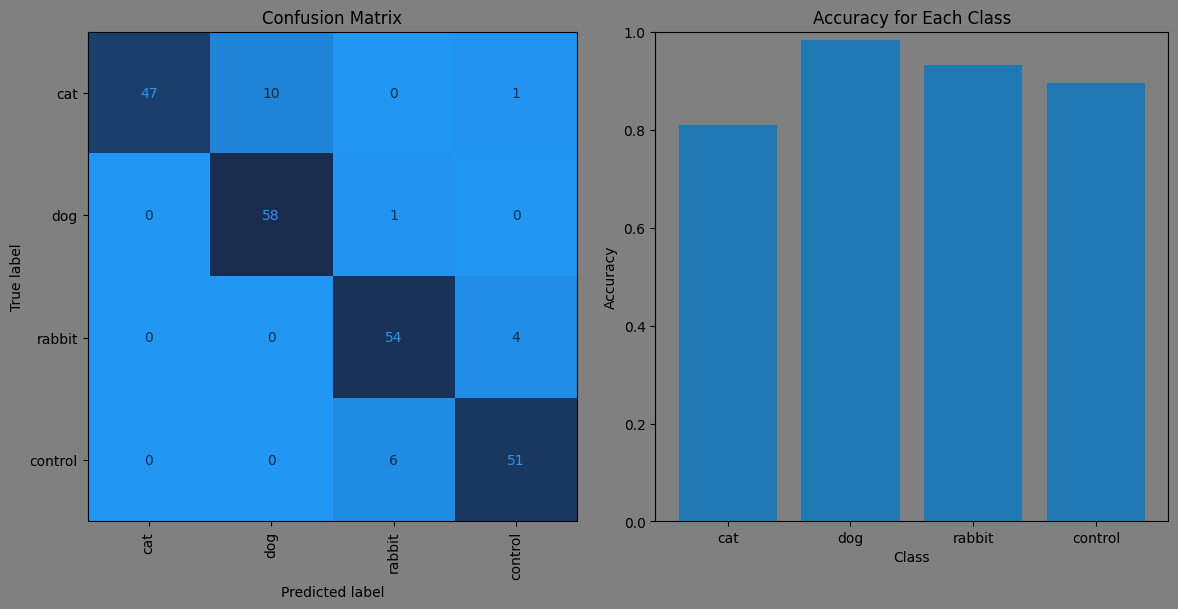

In [21]:
eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(eegsuperconv.parameters(), lr=0.00001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(eegsuperconv, 
                                                                        train_dataloader, 
                                                                        val_dataloader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=2000, 
                                                                        patience=-1, 
                                                                        verbose=100)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(eegsuperconv, train_dataloader, device,
                        class_names=eeg_dataset.class_mapping.keys())

# Evaluate the model on the validation set
evaluate_class_metrics(eegsuperconv, val_dataloader, device, print_metrics=False,
                        class_names=eeg_dataset.class_mapping.keys())

In [23]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self, input_channels, hidden_size, num_layers, num_classes, kernel_size):
        super(LSTM_CNN_Model, self).__init__()
        self.lstm = nn.LSTM(input_channels, hidden_size, num_layers, batch_first=True)
        self.cnn = nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)

        # CNN layer
        cnn_out = self.cnn(lstm_out.permute(0, 2, 1))  # Conv1d expects (batch_size, in_channels, seq_len)

        cnn_out = self.relu(cnn_out)

        # Global max pooling
        pooled_out, _ = torch.max(cnn_out, 2)

        # Fully connected layer
        output = self.fc(pooled_out)

        return output

Epoch [1/1000], Train Loss: 1.3870, Train Accuracy: 0.2381, Validation Loss: 1.3846, Validation Accuracy: 0.2629
Epoch [11/1000], Train Loss: 1.3751, Train Accuracy: 0.2748, Validation Loss: 1.3731, Validation Accuracy: 0.2543
Epoch [21/1000], Train Loss: 1.3620, Train Accuracy: 0.3060, Validation Loss: 1.3615, Validation Accuracy: 0.2974
Epoch [31/1000], Train Loss: 1.3785, Train Accuracy: 0.3039, Validation Loss: 1.3719, Validation Accuracy: 0.3405
Epoch [41/1000], Train Loss: 1.3752, Train Accuracy: 0.3050, Validation Loss: 1.3714, Validation Accuracy: 0.3060
Early stopping triggered
Epoch [41/1000], Train Loss: 1.3752, Train Accuracy: 0.3050, Validation Loss: 1.3714, Validation Accuracy: 0.3060


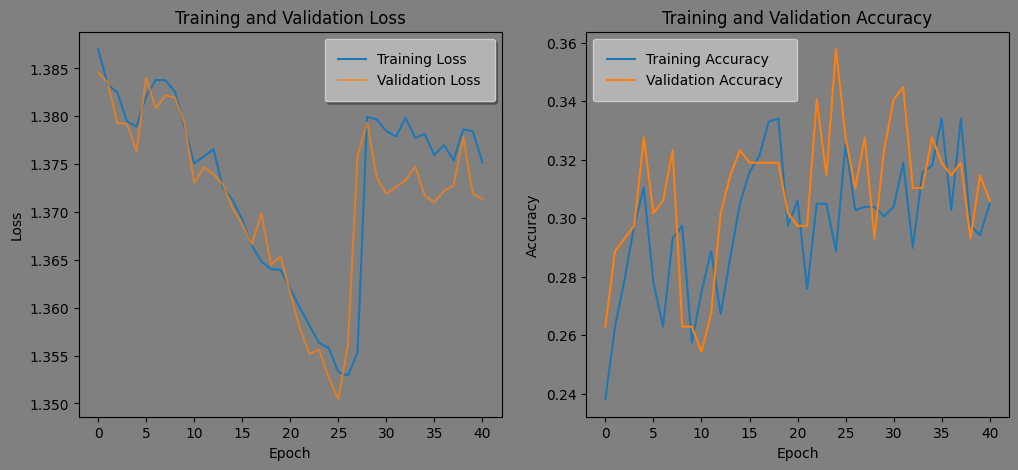

Total correct predictions: 276/928
Overall accuracy: 0.2974
Correct predictions for cat: 160/235; Accuracy: 0.6809
Correct predictions for dog: 0/234; Accuracy: 0.0000
Correct predictions for rabbit: 42/231; Accuracy: 0.1818
Correct predictions for control: 74/228; Accuracy: 0.3246


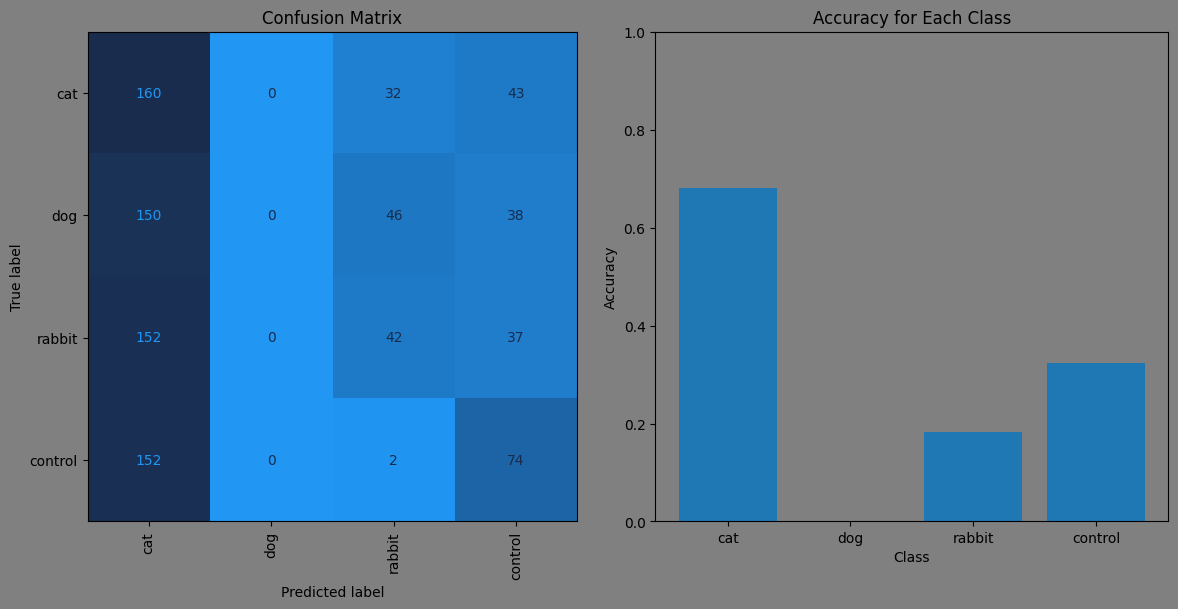

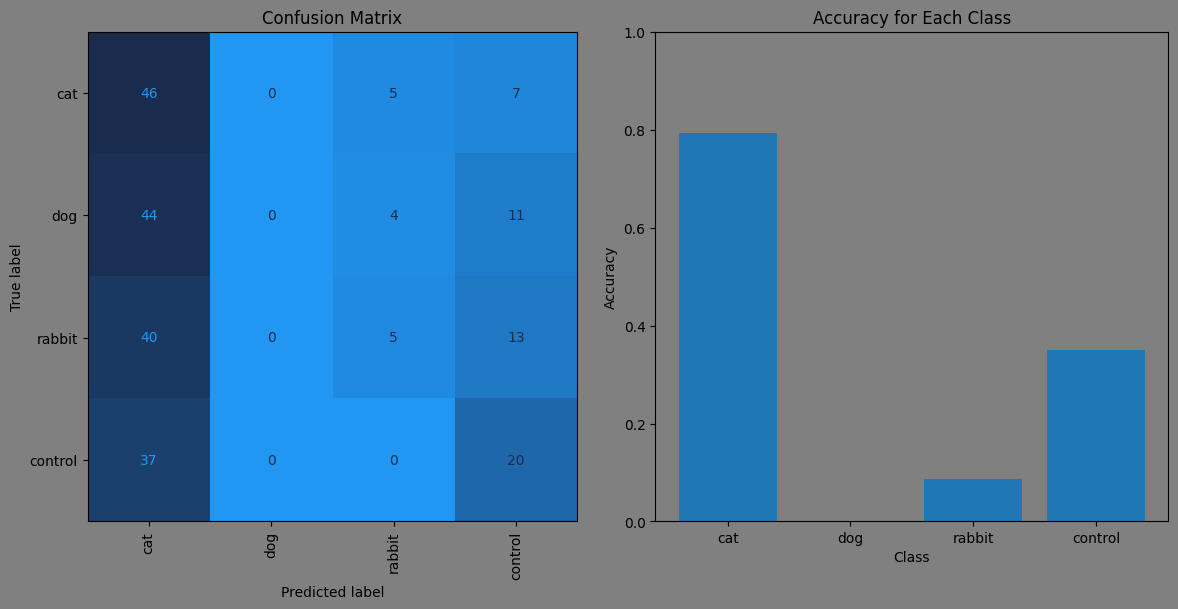

In [17]:
lstm_cnn_model = LSTM_CNN_Model(hidden_size=64,
                                    num_layers=1,
                                    num_classes=4,
                                    input_channels=16,
                                    kernel_size=3).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer = optim.Adam(lstm_cnn_model.parameters(), lr=0.0001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(lstm_cnn_model, 
                                                                        train_dataloader, 
                                                                        val_dataloader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=1000, 
                                                                        patience=15, 
                                                                        verbose=10)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(lstm_cnn_model, train_dataloader, device,
                        class_names=['cat', 'dog', 'rabbit', 'control'])

# Evaluate the model on the validation set
evaluate_class_metrics(lstm_cnn_model, val_dataloader, device, print_metrics=False,
                        class_names=['cat', 'dog', 'rabbit', 'control'])


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EEGLstmConv(nn.Module):
    def __init__(self, num_channels, hidden_size, num_classes):
        super(EEGLstmConv, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=num_channels, hidden_size=hidden_size, batch_first=True)
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Adaptive pooling to make it size-independent
        # unlike nn.MaxPool1d, nn.AdaptiveAvgPool1d can work with any input size
        # nn.AdaptiveAvgPool1d(1) means that the output size will be (batch_size, num_channels, 1)
        self.adap_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layer
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # LSTM layer expects input shape (batch, seq, feature)
        x, _ = self.lstm(x)

        # Transpose to match Conv1d input shape (batch, channel, seq)
        x = x.transpose(1, 2)

        # Convolutional layers with ReLU activations and pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Adaptive pooling and flattening
        x = self.adap_pool(x) 
        x = torch.flatten(x, 1)

        # Fully connected layer for classification
        x = self.fc(x)

        return x

# Example usage
# model = EEGLstmConv(num_channels=16, hidden_size=50, num_classes=4)
# output = model(eeg_signal)  # eeg_signal should be a batch from your DataLoader



Epoch [1/1000], Train Loss: 1.3829, Train Accuracy: 0.2716, Validation Loss: 1.3810, Validation Accuracy: 0.3017
Epoch [11/1000], Train Loss: 1.2882, Train Accuracy: 0.3534, Validation Loss: 1.3225, Validation Accuracy: 0.2974
Epoch [21/1000], Train Loss: 1.1447, Train Accuracy: 0.4170, Validation Loss: 1.2027, Validation Accuracy: 0.3491
Epoch [31/1000], Train Loss: 1.1238, Train Accuracy: 0.4537, Validation Loss: 1.2080, Validation Accuracy: 0.3534
Epoch [41/1000], Train Loss: 1.1105, Train Accuracy: 0.4569, Validation Loss: 1.1969, Validation Accuracy: 0.3793
Epoch [51/1000], Train Loss: 1.0990, Train Accuracy: 0.4450, Validation Loss: 1.1659, Validation Accuracy: 0.3534
Epoch [61/1000], Train Loss: 1.1043, Train Accuracy: 0.4353, Validation Loss: 1.2055, Validation Accuracy: 0.3707
Early stopping triggered
Epoch [65/1000], Train Loss: 1.2161, Train Accuracy: 0.3664, Validation Loss: 1.1896, Validation Accuracy: 0.3879


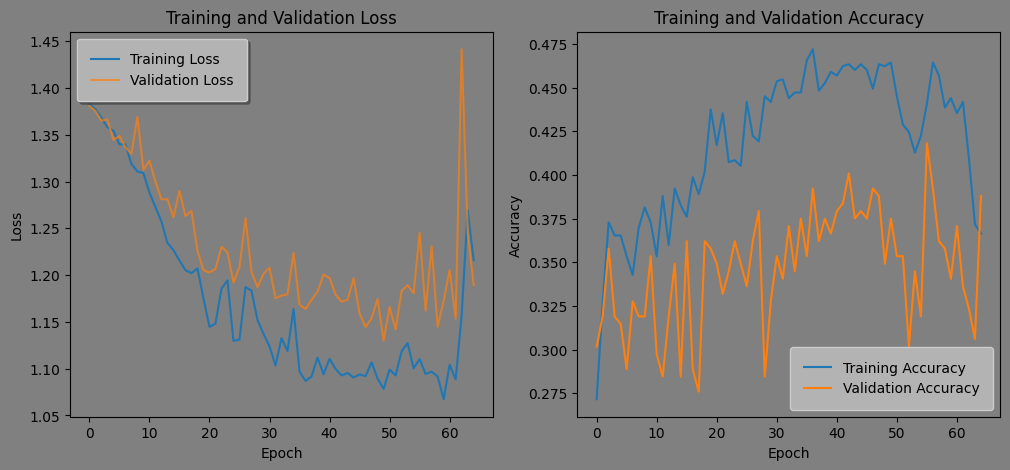

Total correct predictions: 382/928
Overall accuracy: 0.4116
Correct predictions for cat: 77/235; Accuracy: 0.3277
Correct predictions for dog: 119/234; Accuracy: 0.5085
Correct predictions for rabbit: 73/231; Accuracy: 0.3160
Correct predictions for control: 113/228; Accuracy: 0.4956


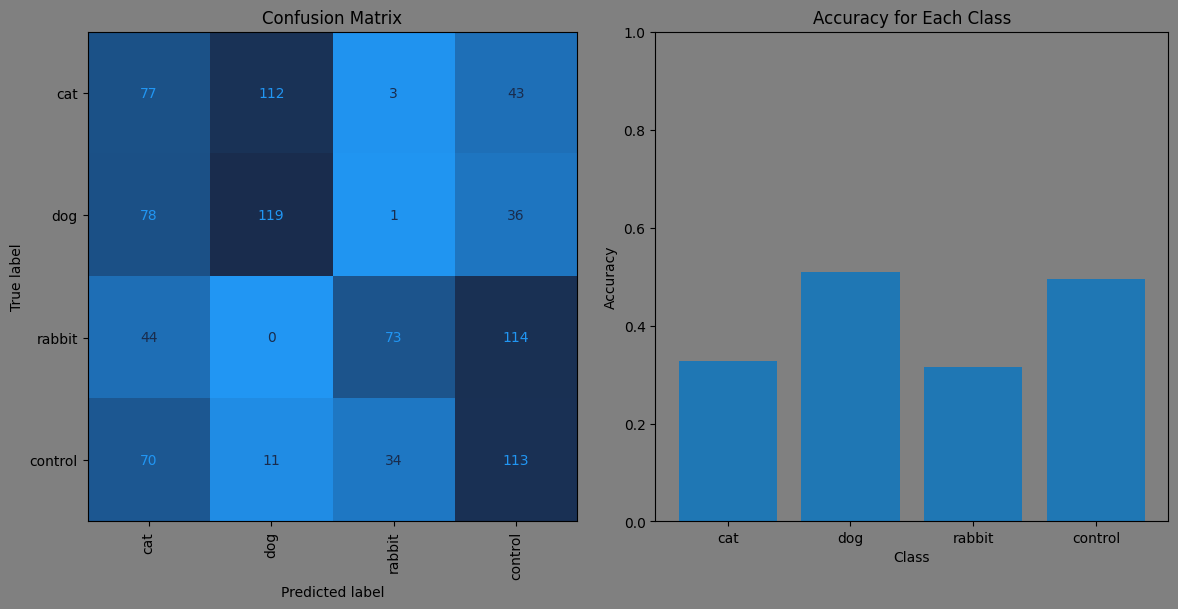

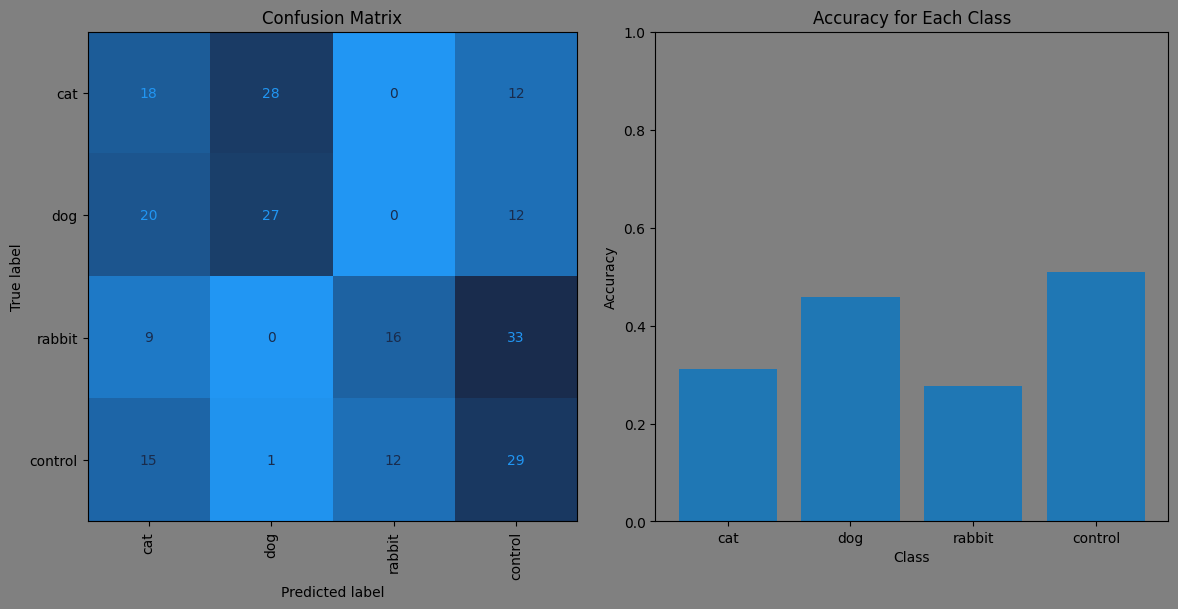

In [19]:

eeglstmconv = EEGLstmConv(num_channels=16, hidden_size=50, num_classes=4).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (example: using Adam)
optimizer = optim.Adam(eeglstmconv.parameters(), lr=0.0001)

# Training loop
train_losses, train_accuracies, val_losses, val_accuracies = train_model(eeglstmconv, 
                                                                        train_dataloader, 
                                                                        val_dataloader, 
                                                                        criterion, 
                                                                        optimizer, 
                                                                        device, 
                                                                        num_epochs=1000, 
                                                                        patience=15, 
                                                                        verbose=10)

# Plot the training and validation losses
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the model on the training set
evaluate_class_metrics(eeglstmconv, train_dataloader, device,
                        class_names=['cat', 'dog', 'rabbit', 'control'])

# Evaluate the model on the validation set
evaluate_class_metrics(eeglstmconv, val_dataloader, device, print_metrics=False,
                        class_names=['cat', 'dog', 'rabbit', 'control'])


## Full Dataset

Training set class counts: {1: 948, 2: 946, 0: 949, 3: 940}
Validation set class counts: {0: 237, 3: 235, 1: 237, 2: 237}
Training set class percentages:
1: 25.1%
2: 25.0%
0: 25.1%
3: 24.8%
Validation set class percentages:
0: 25.1%
3: 24.8%
1: 25.1%
2: 25.1%
------------------- EEGConv -------------------
Epoch [1/200], Train Loss: 1.4943, Train Accuracy: 0.2498, Validation Loss: 1.4942, Validation Accuracy: 0.2505
Epoch [51/200], Train Loss: 1.4934, Train Accuracy: 0.2501, Validation Loss: 1.4928, Validation Accuracy: 0.2505
Epoch [101/200], Train Loss: 1.4928, Train Accuracy: 0.2501, Validation Loss: 1.4935, Validation Accuracy: 0.2505
Epoch [151/200], Train Loss: 1.4941, Train Accuracy: 0.2501, Validation Loss: 1.4921, Validation Accuracy: 0.2505
Epoch [200/200], Train Loss: 1.4934, Train Accuracy: 0.2501, Validation Loss: 1.4928, Validation Accuracy: 0.2505


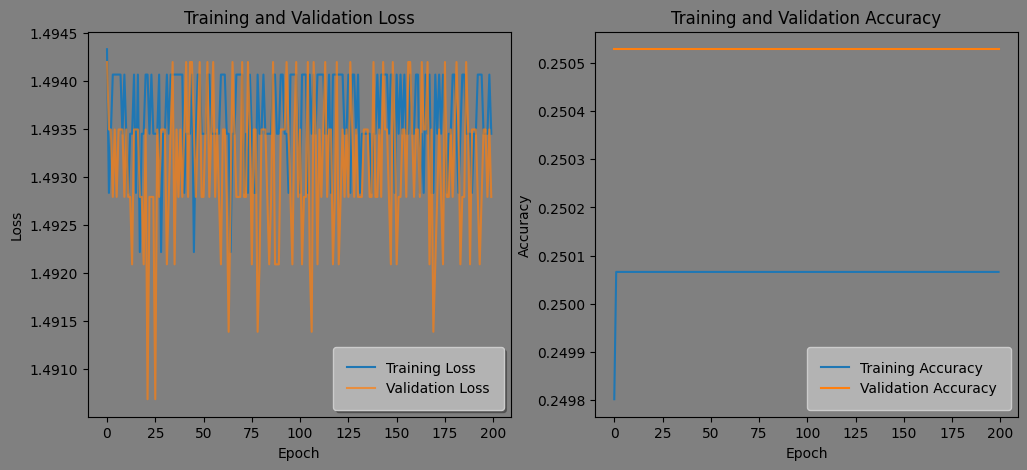

Total correct predictions: 946/3783
Overall accuracy: 0.2501
Correct predictions for cat: 0/949; Accuracy: 0.0000
Correct predictions for dog: 0/948; Accuracy: 0.0000
Correct predictions for rabbit: 946/946; Accuracy: 1.0000
Correct predictions for control: 0/940; Accuracy: 0.0000


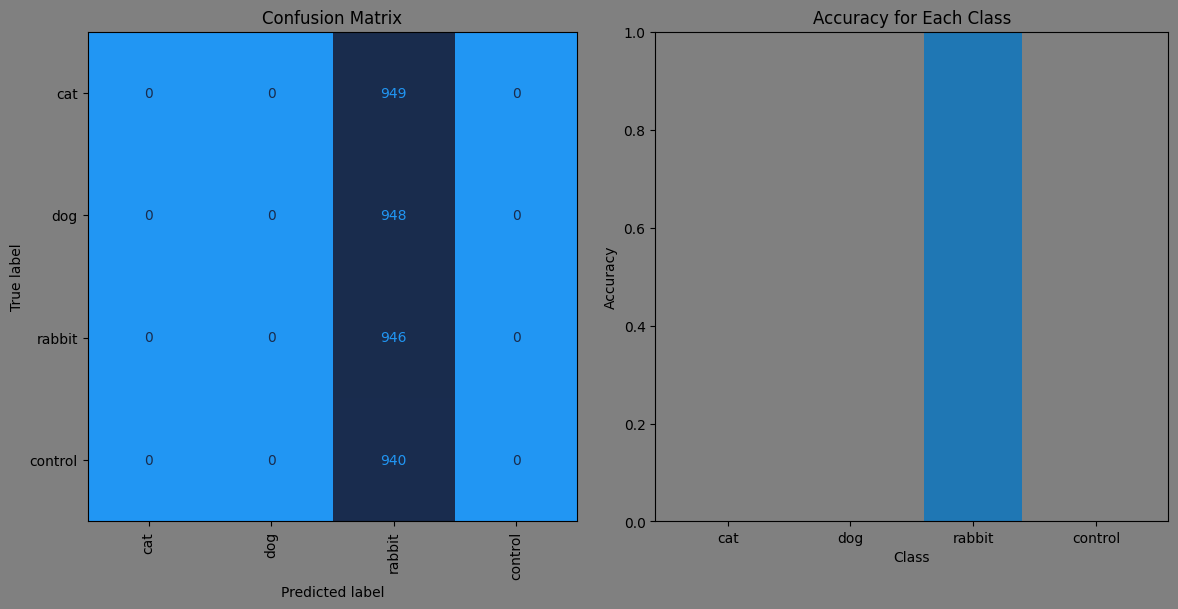

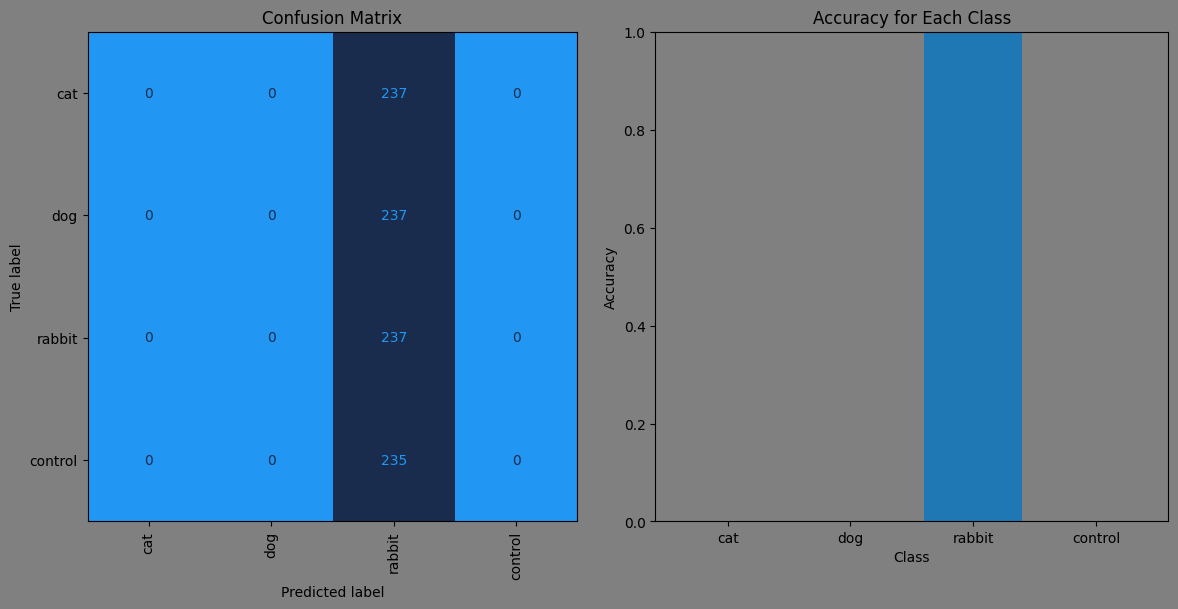

------------------- EEGLSTM -------------------
Epoch [1/200], Train Loss: 1.3861, Train Accuracy: 0.2569, Validation Loss: 1.3859, Validation Accuracy: 0.2706
Epoch [51/200], Train Loss: 1.3592, Train Accuracy: 0.3159, Validation Loss: 1.3813, Validation Accuracy: 0.2770
Epoch [101/200], Train Loss: 1.3385, Train Accuracy: 0.3381, Validation Loss: 1.3487, Validation Accuracy: 0.3118
Epoch [151/200], Train Loss: 1.3438, Train Accuracy: 0.3310, Validation Loss: 1.3554, Validation Accuracy: 0.2981
Epoch [200/200], Train Loss: 1.3572, Train Accuracy: 0.3127, Validation Loss: 1.3646, Validation Accuracy: 0.2939


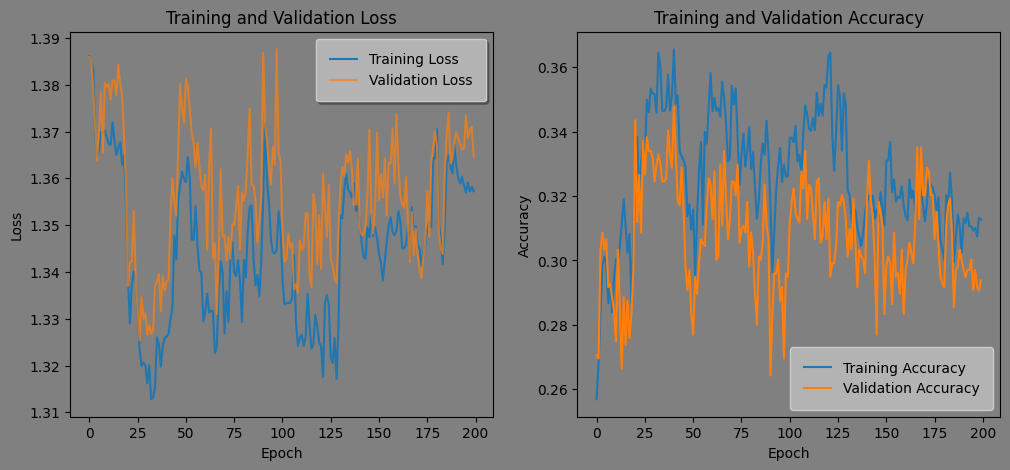

Total correct predictions: 1195/3783
Overall accuracy: 0.3159
Correct predictions for cat: 796/949; Accuracy: 0.8388
Correct predictions for dog: 124/948; Accuracy: 0.1308
Correct predictions for rabbit: 84/946; Accuracy: 0.0888
Correct predictions for control: 191/940; Accuracy: 0.2032


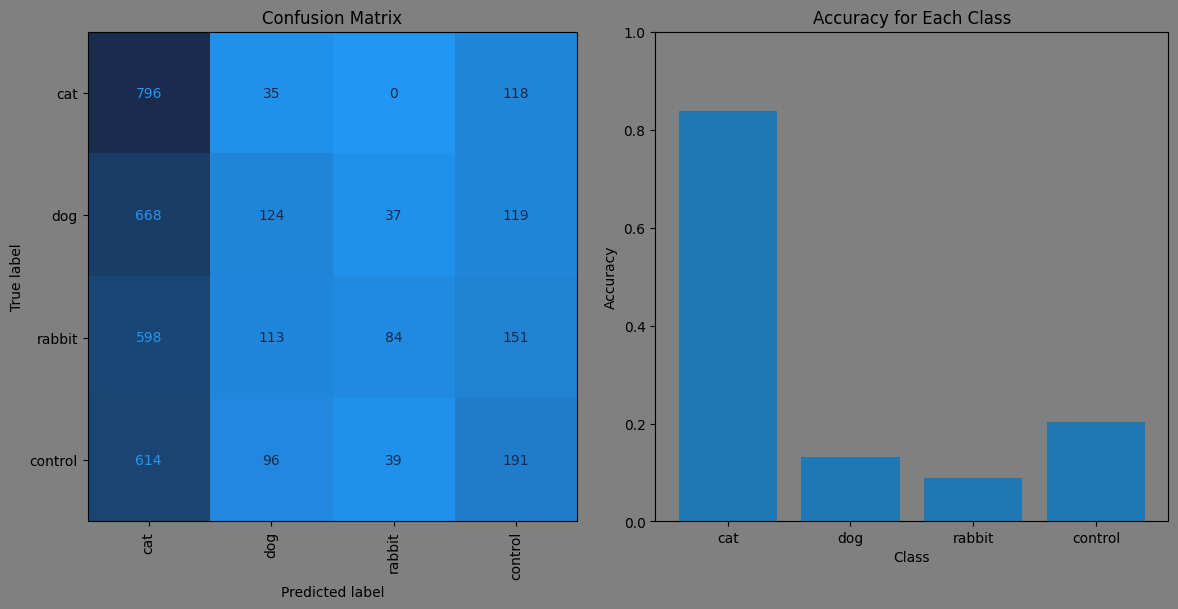

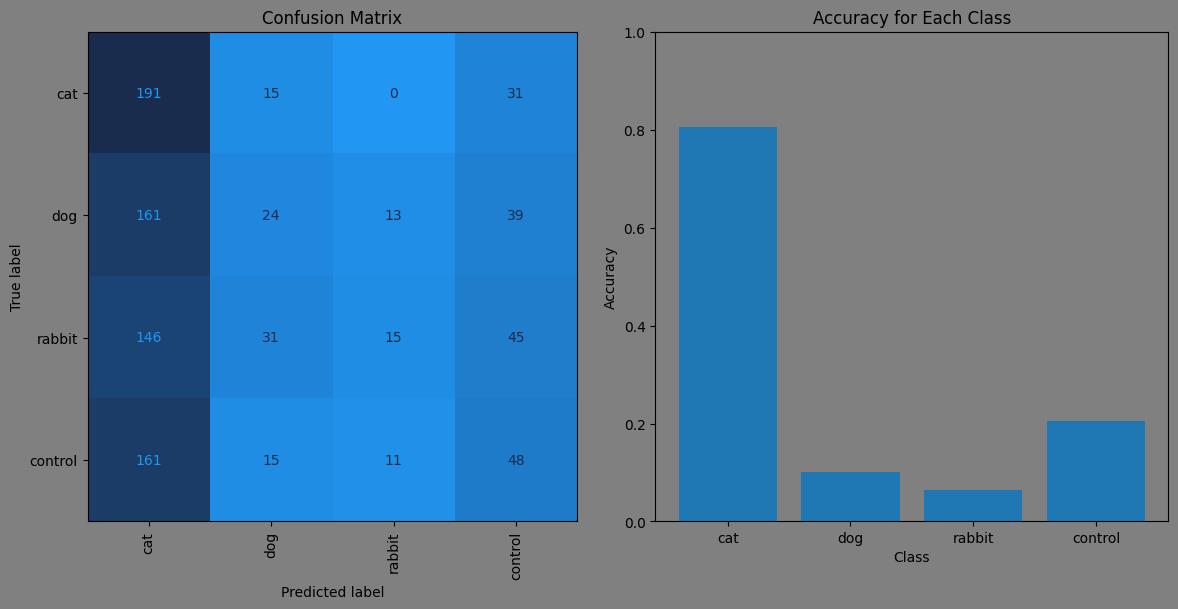

------------------- LSTM_CNN_Model -------------------
Epoch [1/200], Train Loss: 1.3843, Train Accuracy: 0.2638, Validation Loss: 1.3808, Validation Accuracy: 0.2833
Epoch [51/200], Train Loss: 1.2082, Train Accuracy: 0.3910, Validation Loss: 1.2231, Validation Accuracy: 0.3732
Epoch [101/200], Train Loss: 1.2054, Train Accuracy: 0.3669, Validation Loss: 1.2208, Validation Accuracy: 0.3446
Epoch [151/200], Train Loss: 1.1830, Train Accuracy: 0.3762, Validation Loss: 1.1956, Validation Accuracy: 0.3763
Epoch [200/200], Train Loss: 1.1874, Train Accuracy: 0.3746, Validation Loss: 1.2121, Validation Accuracy: 0.3510


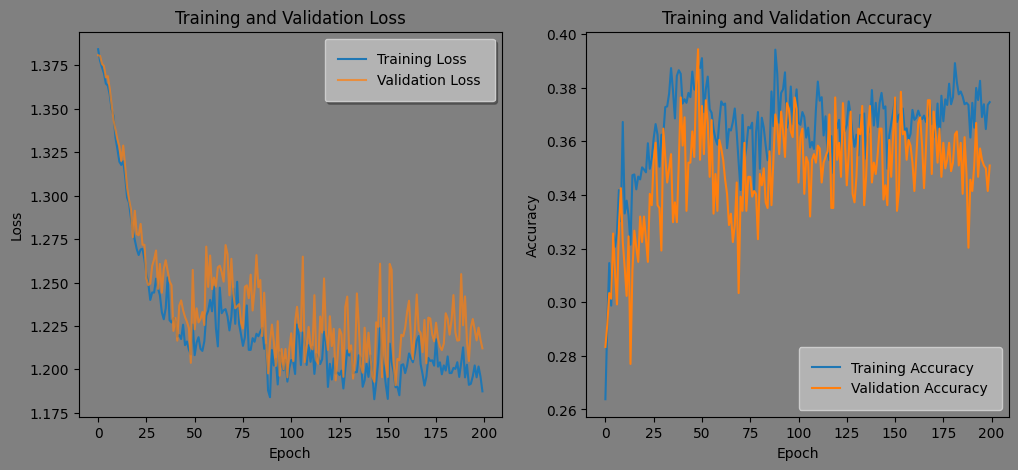

Total correct predictions: 1439/3783
Overall accuracy: 0.3804
Correct predictions for cat: 234/949; Accuracy: 0.2466
Correct predictions for dog: 165/948; Accuracy: 0.1741
Correct predictions for rabbit: 521/946; Accuracy: 0.5507
Correct predictions for control: 519/940; Accuracy: 0.5521


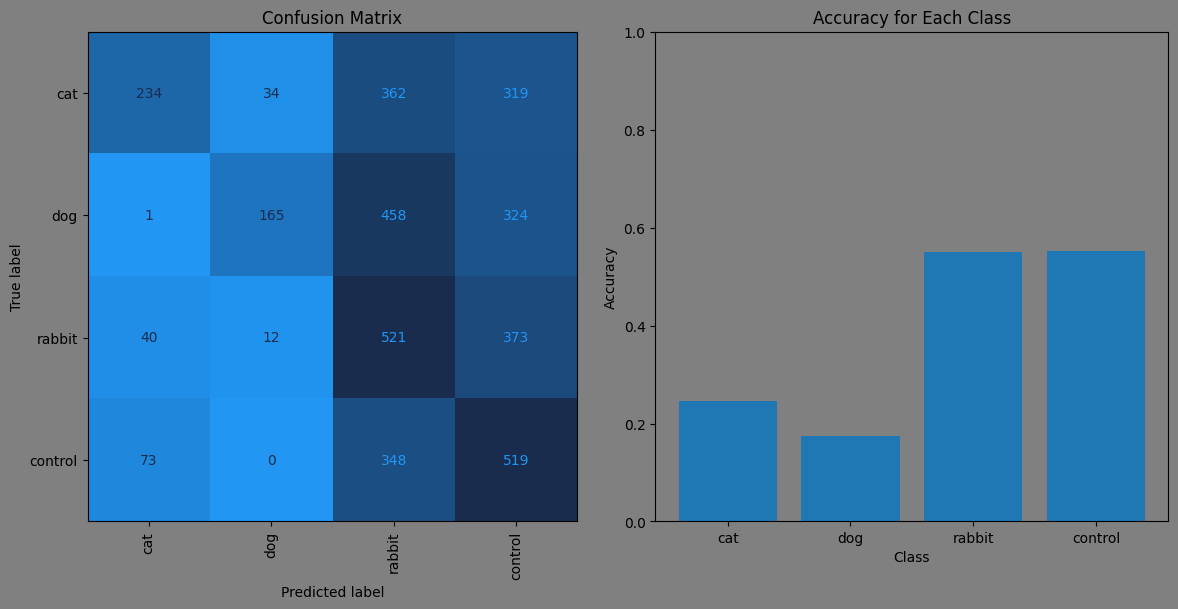

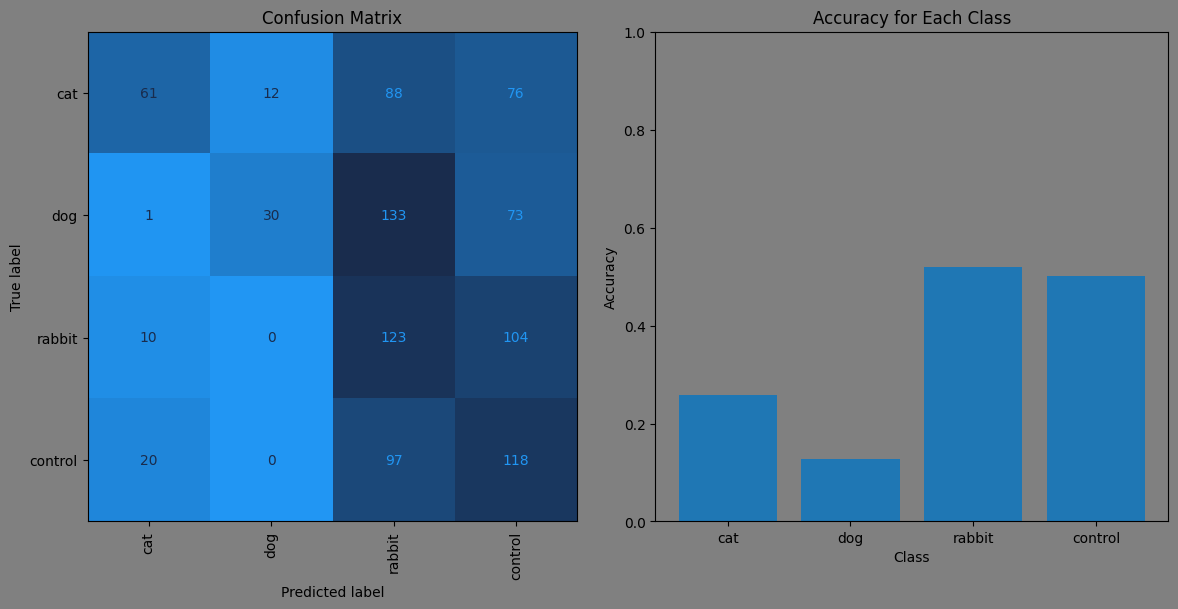

------------------- EEGLstmConv -------------------
Epoch [1/200], Train Loss: 1.3842, Train Accuracy: 0.2707, Validation Loss: 1.3832, Validation Accuracy: 0.2833
Epoch [51/200], Train Loss: 1.2197, Train Accuracy: 0.3672, Validation Loss: 1.2536, Validation Accuracy: 0.3541
Epoch [101/200], Train Loss: 1.1627, Train Accuracy: 0.4007, Validation Loss: 1.1957, Validation Accuracy: 0.3626
Epoch [151/200], Train Loss: 1.1205, Train Accuracy: 0.4177, Validation Loss: 1.1346, Validation Accuracy: 0.4133
Epoch [200/200], Train Loss: 1.1651, Train Accuracy: 0.4052, Validation Loss: 1.2161, Validation Accuracy: 0.3816


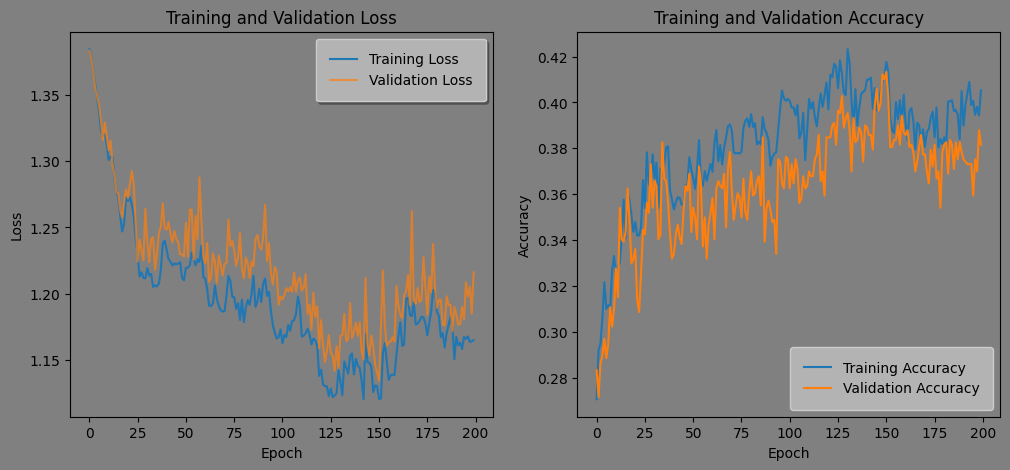

Total correct predictions: 1536/3783
Overall accuracy: 0.4060
Correct predictions for cat: 588/949; Accuracy: 0.6196
Correct predictions for dog: 228/948; Accuracy: 0.2405
Correct predictions for rabbit: 442/946; Accuracy: 0.4672
Correct predictions for control: 278/940; Accuracy: 0.2957


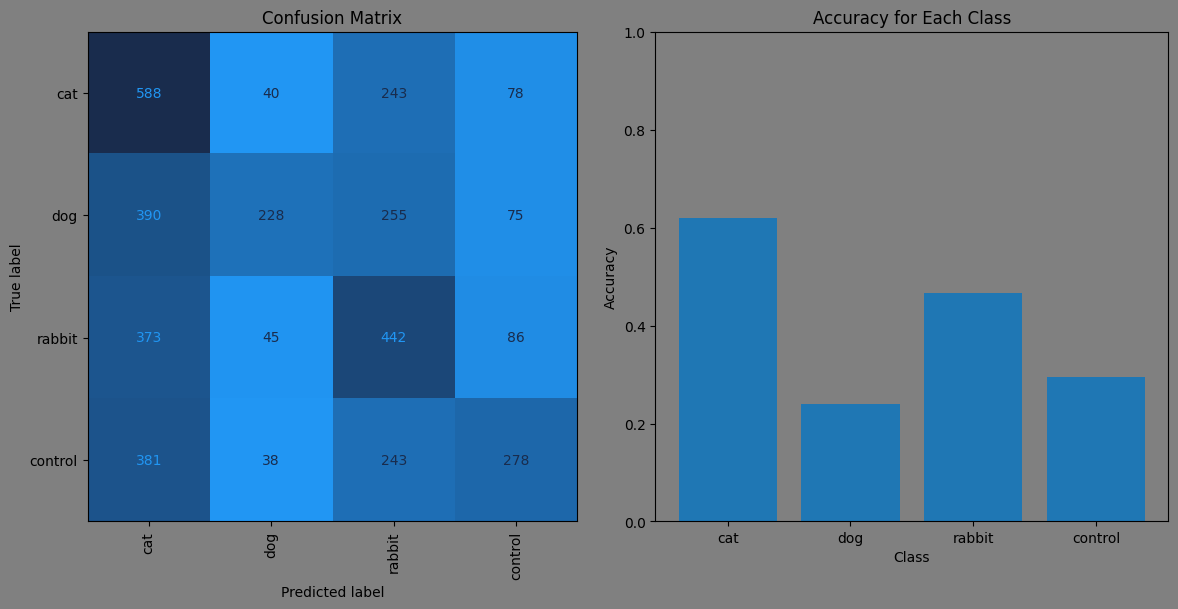

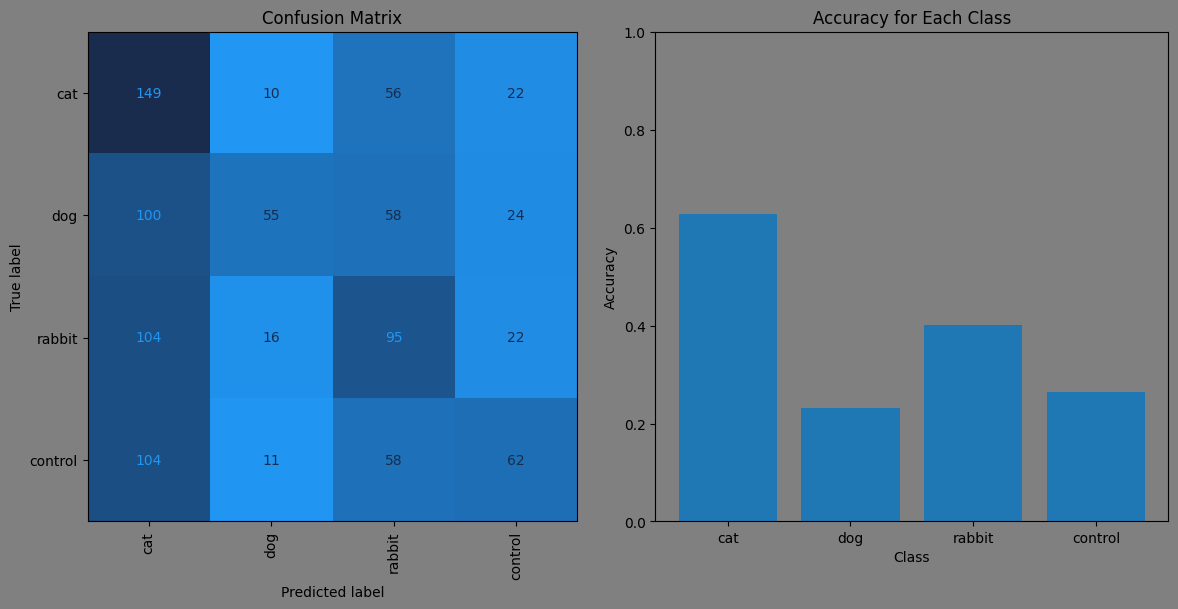

------------------- EEGSuperConv -------------------
Epoch [1/200], Train Loss: 28.5063, Train Accuracy: 0.2834, Validation Loss: 22.8659, Validation Accuracy: 0.3076
Epoch [51/200], Train Loss: 0.8784, Train Accuracy: 0.6098, Validation Loss: 1.0275, Validation Accuracy: 0.5867
Epoch [101/200], Train Loss: 0.5968, Train Accuracy: 0.7502, Validation Loss: 0.4950, Validation Accuracy: 0.8288
Epoch [151/200], Train Loss: 0.4593, Train Accuracy: 0.8195, Validation Loss: 0.3503, Validation Accuracy: 0.8562
Epoch [200/200], Train Loss: 0.3455, Train Accuracy: 0.8604, Validation Loss: 0.2985, Validation Accuracy: 0.8879


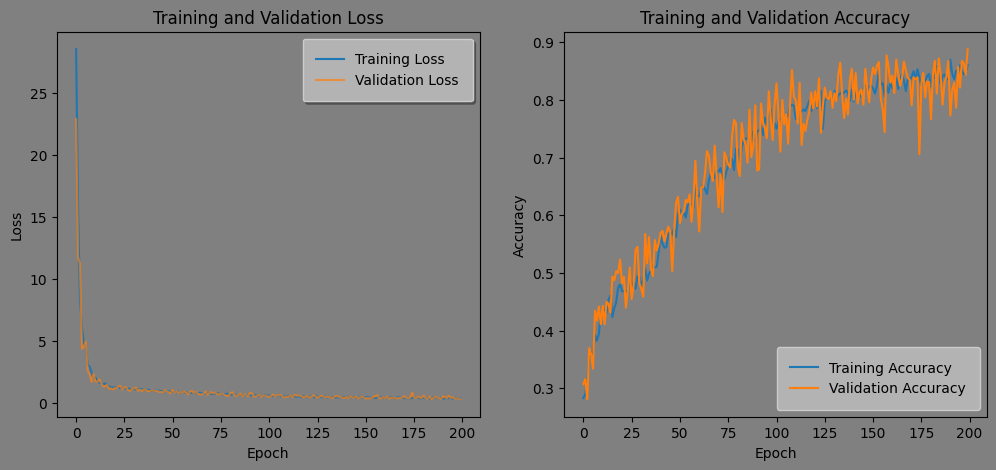

Total correct predictions: 3437/3783
Overall accuracy: 0.9085
Correct predictions for cat: 903/949; Accuracy: 0.9515
Correct predictions for dog: 862/948; Accuracy: 0.9093
Correct predictions for rabbit: 835/946; Accuracy: 0.8827
Correct predictions for control: 837/940; Accuracy: 0.8904


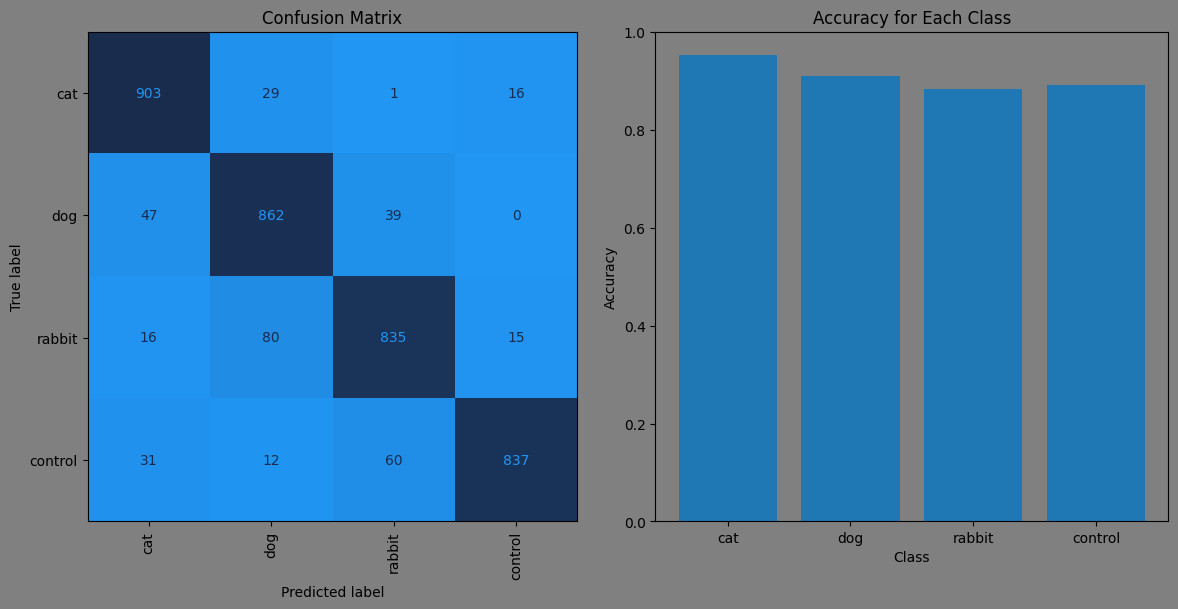

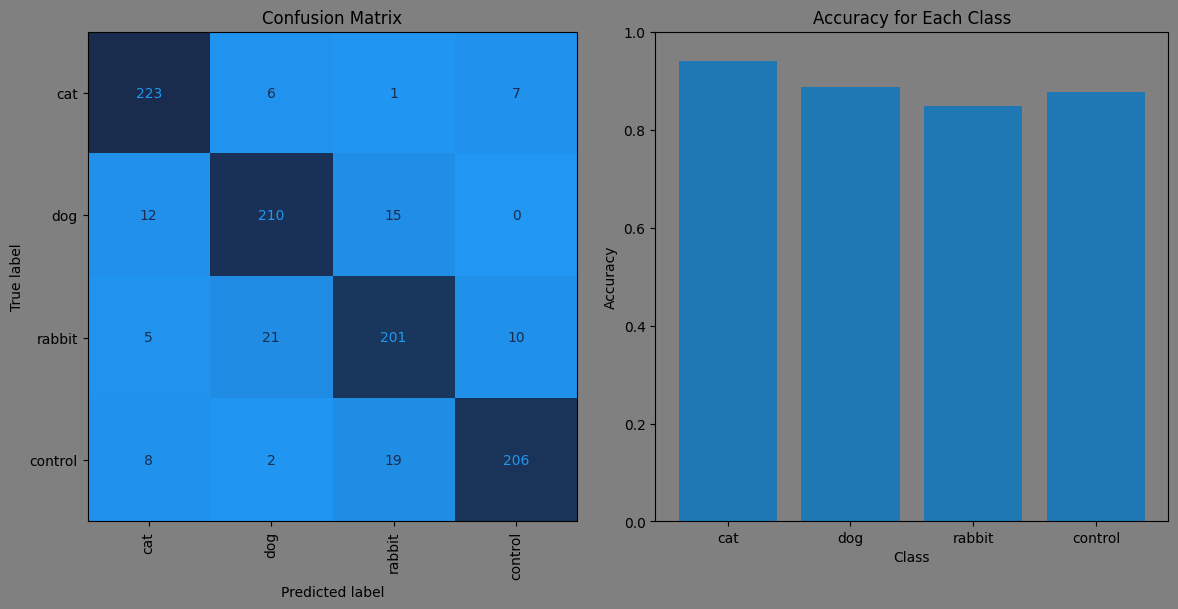

In [20]:
# Dataset object
full_eeg_dataset = EEGDataset('SynapSee_data.json')
full_train_dataset, full_val_dataset = stratified_split(full_eeg_dataset,
                                                        stratify_by='class',
                                                        random_state=420,
                                                        print_distributions=True)
batch_size = 10
full_train_dataloader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
full_val_dataloader = DataLoader(full_val_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

lr = 0.0001
epochs = 200
patience = -1
verbose = 50

print ("------------------- EEGConv -------------------") 
# Training loop for eegconv
eegconv = EEGConv(num_classes=4).to(device)
optimizer = optim.Adam(eegconv.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eegconv,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)

# Evaluate the model
evaluate_class_metrics(eegconv, full_train_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'])
evaluate_class_metrics(eegconv, full_val_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'], print_metrics=False)

print ("------------------- EEGLSTM -------------------")
# Training loop for eeglstm
eeglstm = EEGLSTM(input_size=16, hidden_size=50, num_layers=2, num_classes=4).to(device)
optimizer = optim.Adam(eeglstm.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eeglstm,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(eeglstm, full_train_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'])
evaluate_class_metrics(eeglstm, full_val_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'], print_metrics=False)

print ("------------------- LSTM_CNN_Model -------------------")
# Training loop for lstm_cnn_model
lstm_cnn_model = LSTM_CNN_Model(hidden_size=64,
                                    num_layers=1,
                                    num_classes=4,
                                    input_channels=16,
                                    kernel_size=3).to(device)
optimizer = optim.Adam(lstm_cnn_model.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(lstm_cnn_model,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(lstm_cnn_model, full_train_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'])
evaluate_class_metrics(lstm_cnn_model, full_val_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'], print_metrics=False)

print ("------------------- EEGLstmConv -------------------")
# Training loop for eeglstmconv
eeglstmconv = EEGLstmConv(num_channels=16, hidden_size=50, num_classes=4).to(device)
optimizer = optim.Adam(eeglstmconv.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eeglstmconv,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(eeglstmconv, full_train_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'])
evaluate_class_metrics(eeglstmconv, full_val_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'], print_metrics=False)


print ("------------------- EEGSuperConv -------------------")
# Training loop for eegsuperconv
eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)
optimizer = optim.Adam(eegsuperconv.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eegsuperconv,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(eegsuperconv, full_train_dataloader, device, 
                       class_names=['cat', 'dog', 'rabbit', 'control'])
evaluate_class_metrics(eegsuperconv, full_val_dataloader, device,
                          class_names=['cat', 'dog', 'rabbit', 'control'], print_metrics=False)




Training set class counts: {1: 1428, 3: 1419, 2: 1426, 0: 1426}
Validation set class counts: {2: 357, 3: 354, 0: 357, 1: 357}
Training set class percentages:
1: 25.1%
3: 24.9%
2: 25.0%
0: 25.0%
Validation set class percentages:
2: 25.1%
3: 24.8%
0: 25.1%
1: 25.1%
------------------- EEGConv -------------------
Epoch [1/300], Train Loss: 202.3126, Train Accuracy: 0.2530, Validation Loss: 101.1613, Validation Accuracy: 0.2575
Epoch [51/300], Train Loss: 1.3864, Train Accuracy: 0.2460, Validation Loss: 1.3890, Validation Accuracy: 0.2386
Epoch [101/300], Train Loss: 1.3863, Train Accuracy: 0.2513, Validation Loss: 1.3884, Validation Accuracy: 0.2386
Epoch [151/300], Train Loss: 1.3863, Train Accuracy: 0.2472, Validation Loss: 1.3881, Validation Accuracy: 0.2386
Epoch [201/300], Train Loss: 1.3863, Train Accuracy: 0.2534, Validation Loss: 1.3879, Validation Accuracy: 0.2379
Epoch [251/300], Train Loss: 1.3863, Train Accuracy: 0.2471, Validation Loss: 1.3876, Validation Accuracy: 0.2379
Epo

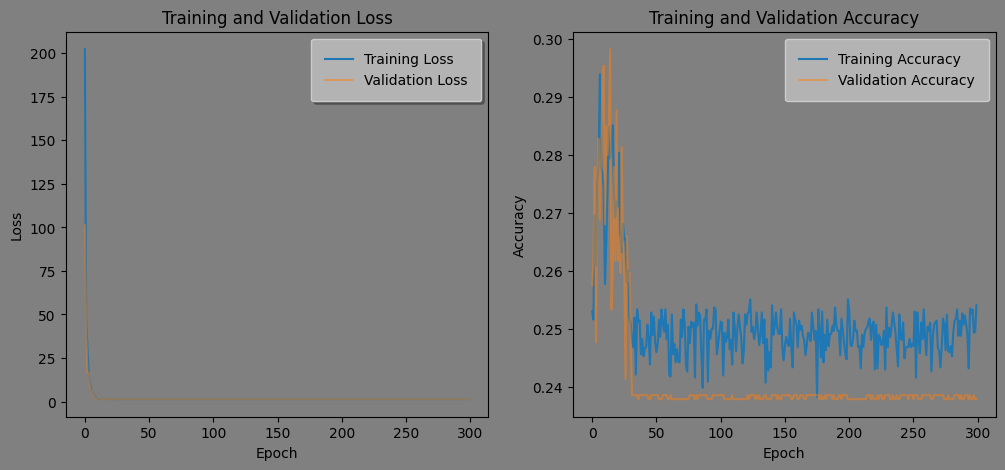

Total correct predictions: 1444/5699
Overall accuracy: 0.2534
Correct predictions for cat: 252/1426; Accuracy: 0.1767
Correct predictions for dog: 0/1428; Accuracy: 0.0000
Correct predictions for rabbit: 1192/1426; Accuracy: 0.8359
Correct predictions for control: 0/1419; Accuracy: 0.0000


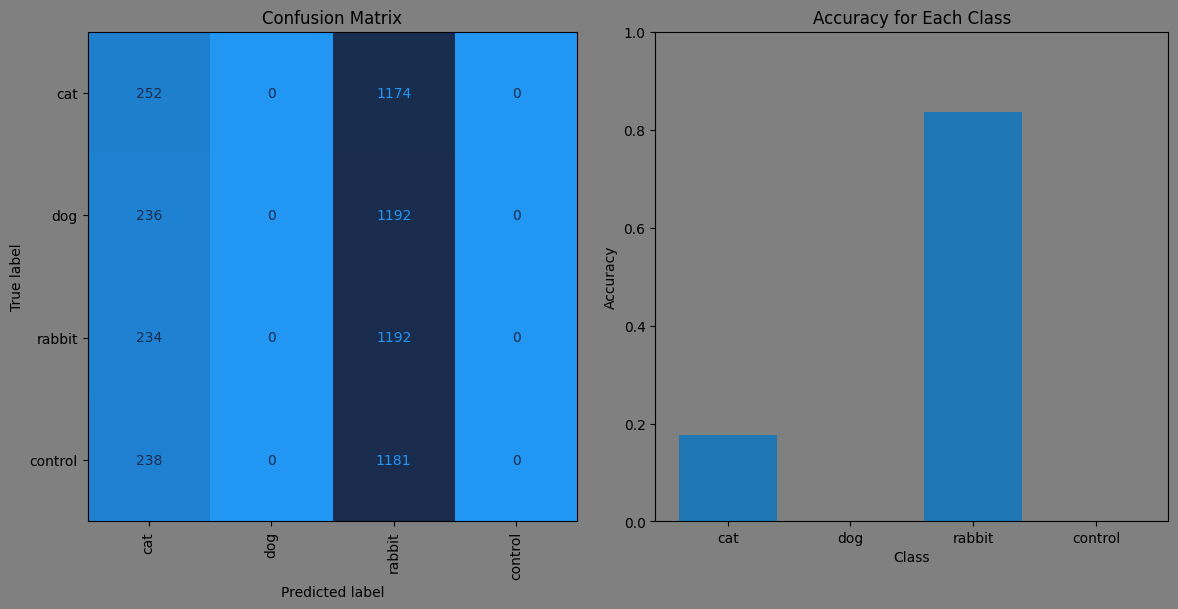

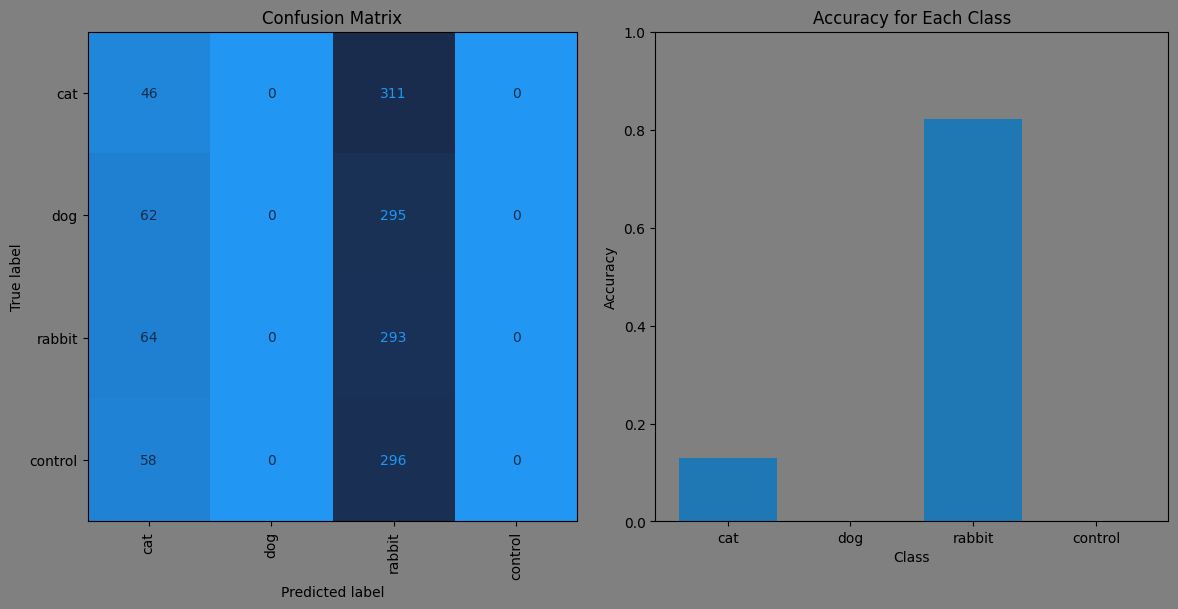

------------------- EEGLSTM -------------------
Epoch [1/300], Train Loss: 1.3874, Train Accuracy: 0.2523, Validation Loss: 1.3862, Validation Accuracy: 0.2547
Epoch [51/300], Train Loss: 1.2631, Train Accuracy: 0.3346, Validation Loss: 1.2553, Validation Accuracy: 0.3172
Epoch [101/300], Train Loss: 1.2707, Train Accuracy: 0.3127, Validation Loss: 1.2761, Validation Accuracy: 0.3018
Epoch [151/300], Train Loss: 1.2717, Train Accuracy: 0.3171, Validation Loss: 1.3218, Validation Accuracy: 0.2779
Epoch [201/300], Train Loss: 1.2996, Train Accuracy: 0.2978, Validation Loss: 1.3018, Validation Accuracy: 0.2807
Epoch [251/300], Train Loss: 1.3057, Train Accuracy: 0.2958, Validation Loss: 1.3086, Validation Accuracy: 0.2730
Epoch [300/300], Train Loss: 1.3100, Train Accuracy: 0.2920, Validation Loss: 1.3083, Validation Accuracy: 0.2751


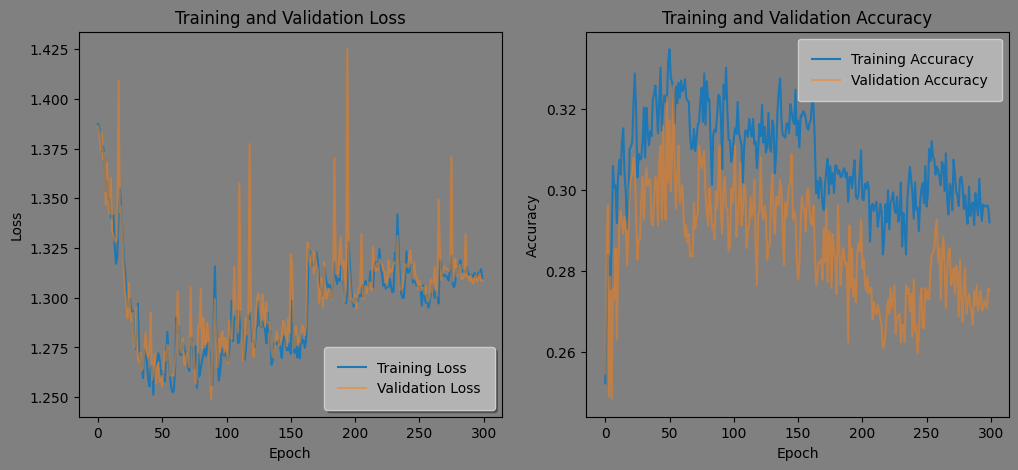

Total correct predictions: 1724/5699
Overall accuracy: 0.3025
Correct predictions for cat: 240/1426; Accuracy: 0.1683
Correct predictions for dog: 647/1428; Accuracy: 0.4531
Correct predictions for rabbit: 81/1426; Accuracy: 0.0568
Correct predictions for control: 756/1419; Accuracy: 0.5328


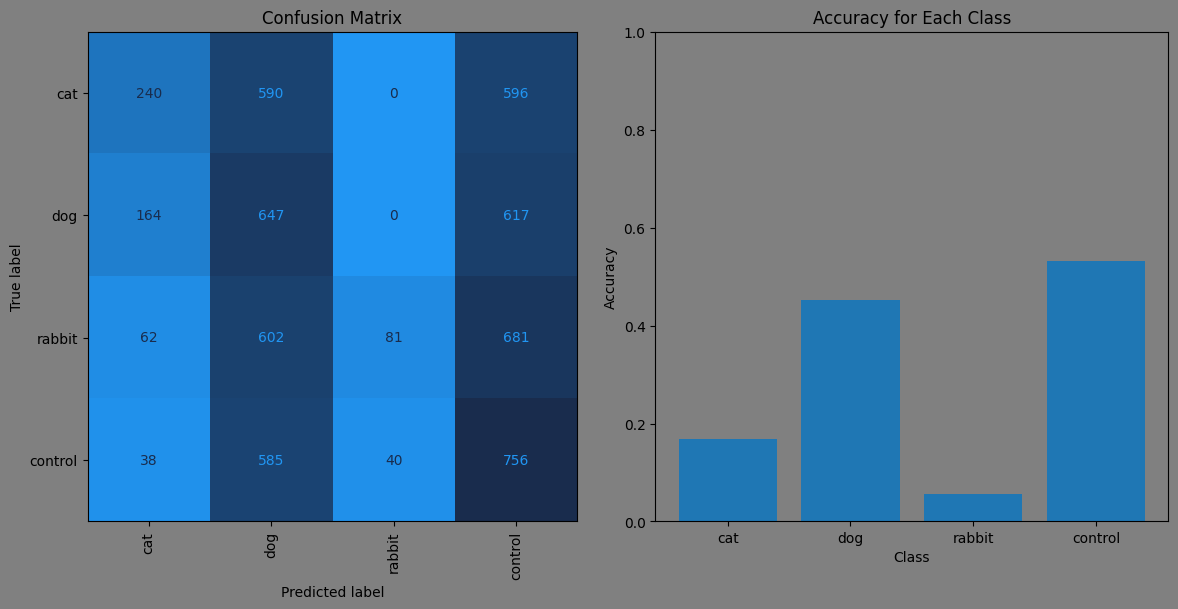

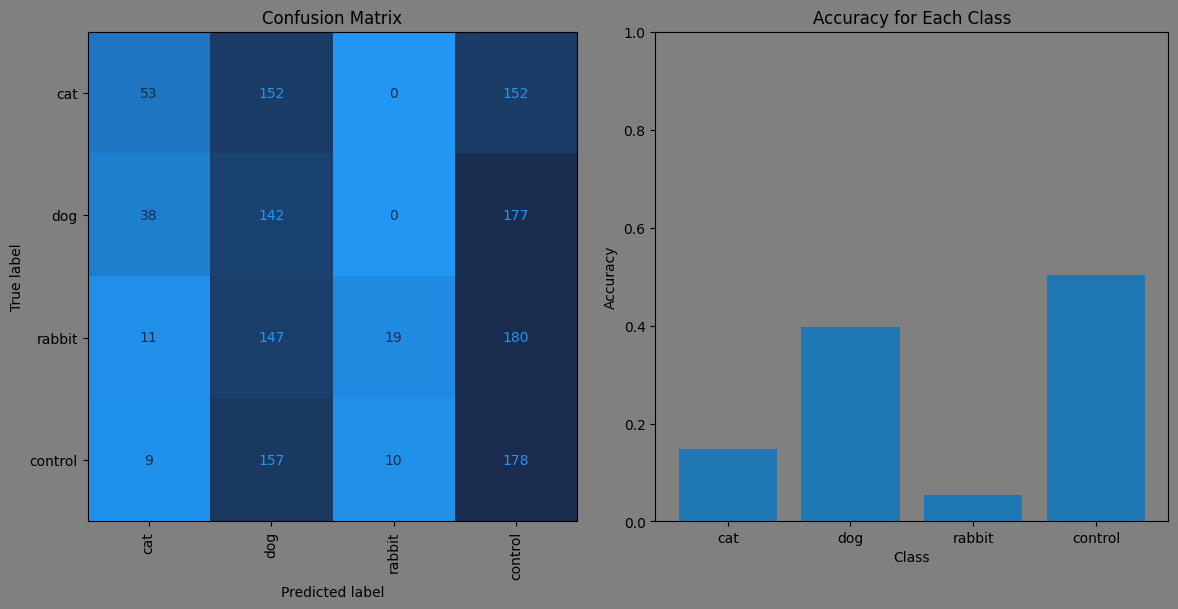

------------------- LSTM_CNN_Model -------------------


NameError: name 'LSTM_CNN_Model' is not defined

In [22]:
# Dataset object
full_eeg_dataset = EEGDataset('SynapSee_data.json')
full_train_dataset, full_val_dataset = stratified_split(full_eeg_dataset,
                                                        stratify_by='class',
                                                        random_state=420,
                                                        print_distributions=True)
batch_size = 10
full_train_dataloader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
full_val_dataloader = DataLoader(full_val_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

lr = 0.0001
epochs = 300
patience = -1
verbose = 50

print ("------------------- EEGConv -------------------") 
# Training loop for eegconv
eegconv = EEGConv(num_classes=4).to(device)
optimizer = optim.Adam(eegconv.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eegconv,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)

# Evaluate the model
evaluate_class_metrics(eegconv, full_train_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(eegconv, full_val_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys(), 
                       print_metrics=False)

print ("------------------- EEGLSTM -------------------")
# Training loop for eeglstm
eeglstm = EEGLSTM(input_size=16, hidden_size=50, num_layers=2, num_classes=4).to(device)
optimizer = optim.Adam(eeglstm.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eeglstm,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(eeglstm, full_train_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(eeglstm, full_val_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys(), 
                       print_metrics=False)


------------------- LSTM_CNN_Model -------------------
Epoch [1/300], Train Loss: 1.3864, Train Accuracy: 0.2622, Validation Loss: 1.3820, Validation Accuracy: 0.2786
Epoch [51/300], Train Loss: 1.2901, Train Accuracy: 0.3067, Validation Loss: 1.2879, Validation Accuracy: 0.3137
Epoch [101/300], Train Loss: 1.2789, Train Accuracy: 0.3148, Validation Loss: 1.2674, Validation Accuracy: 0.3263
Epoch [151/300], Train Loss: 1.2769, Train Accuracy: 0.3388, Validation Loss: 1.2743, Validation Accuracy: 0.3249
Epoch [201/300], Train Loss: 1.2503, Train Accuracy: 0.3366, Validation Loss: 1.2537, Validation Accuracy: 0.3298
Epoch [251/300], Train Loss: 1.2752, Train Accuracy: 0.3095, Validation Loss: 1.2696, Validation Accuracy: 0.3326
Epoch [300/300], Train Loss: 1.2617, Train Accuracy: 0.3278, Validation Loss: 1.2594, Validation Accuracy: 0.3179


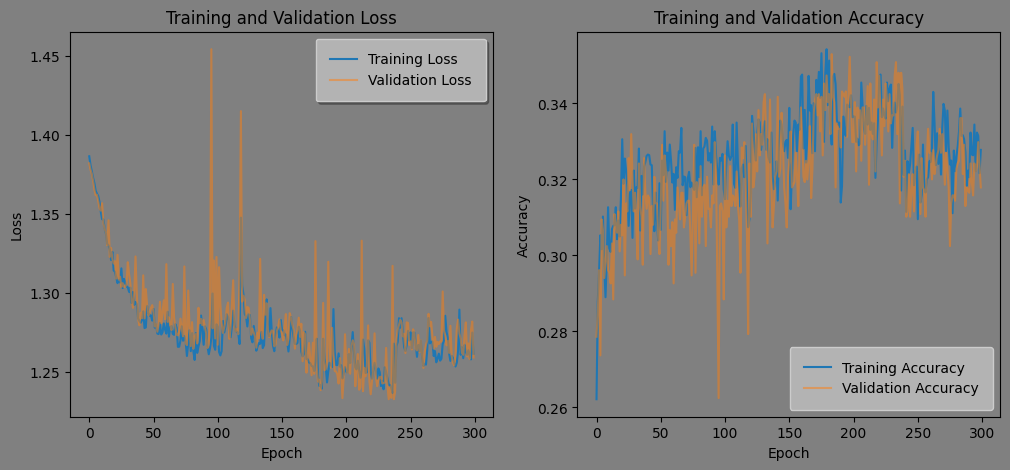

Total correct predictions: 1960/5699
Overall accuracy: 0.3439
Correct predictions for cat: 280/1426; Accuracy: 0.1964
Correct predictions for dog: 613/1428; Accuracy: 0.4293
Correct predictions for rabbit: 624/1426; Accuracy: 0.4376
Correct predictions for control: 443/1419; Accuracy: 0.3122


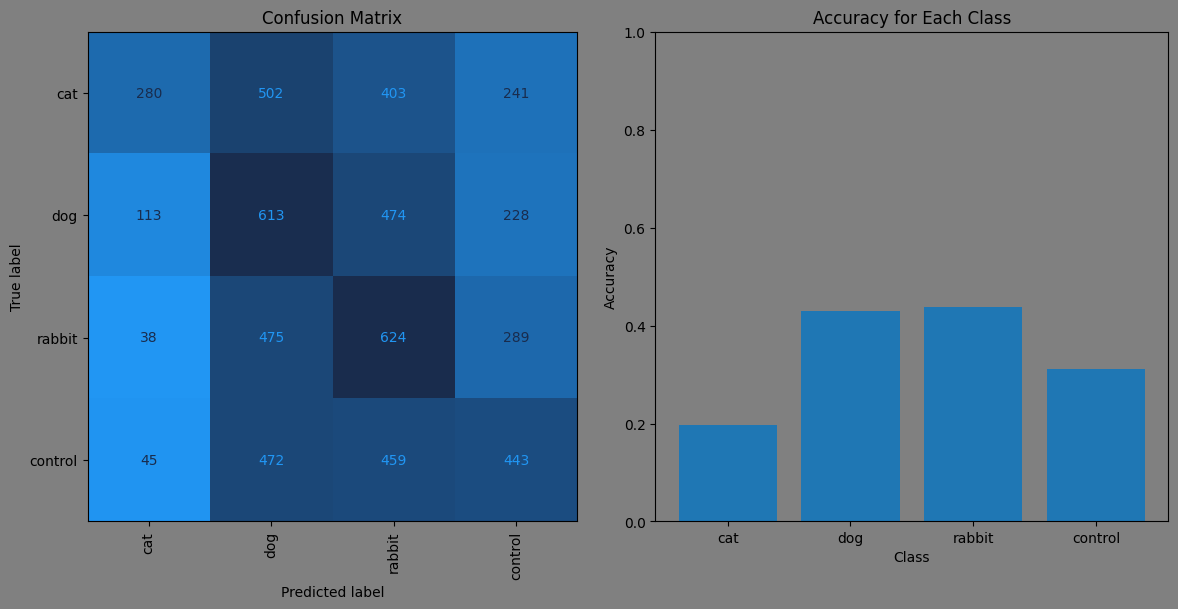

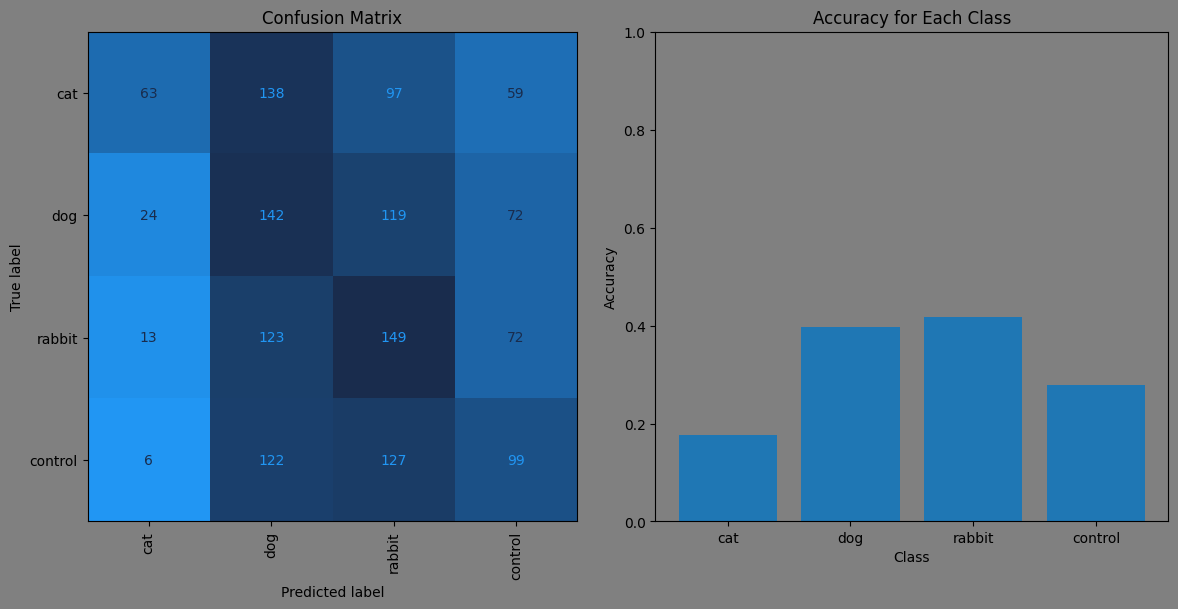

------------------- EEGLstmConv -------------------
Epoch [1/300], Train Loss: 1.3851, Train Accuracy: 0.2641, Validation Loss: 1.3819, Validation Accuracy: 0.2765
Epoch [51/300], Train Loss: 1.2522, Train Accuracy: 0.3390, Validation Loss: 1.2693, Validation Accuracy: 0.3186
Epoch [101/300], Train Loss: 1.2692, Train Accuracy: 0.3423, Validation Loss: 1.2848, Validation Accuracy: 0.3172
Epoch [151/300], Train Loss: 1.2488, Train Accuracy: 0.3422, Validation Loss: 1.2655, Validation Accuracy: 0.3032
Epoch [201/300], Train Loss: 1.2295, Train Accuracy: 0.3485, Validation Loss: 1.2512, Validation Accuracy: 0.3186
Epoch [251/300], Train Loss: 1.2450, Train Accuracy: 0.3444, Validation Loss: 1.2855, Validation Accuracy: 0.3004
Epoch [300/300], Train Loss: 1.2406, Train Accuracy: 0.3476, Validation Loss: 1.2676, Validation Accuracy: 0.3123


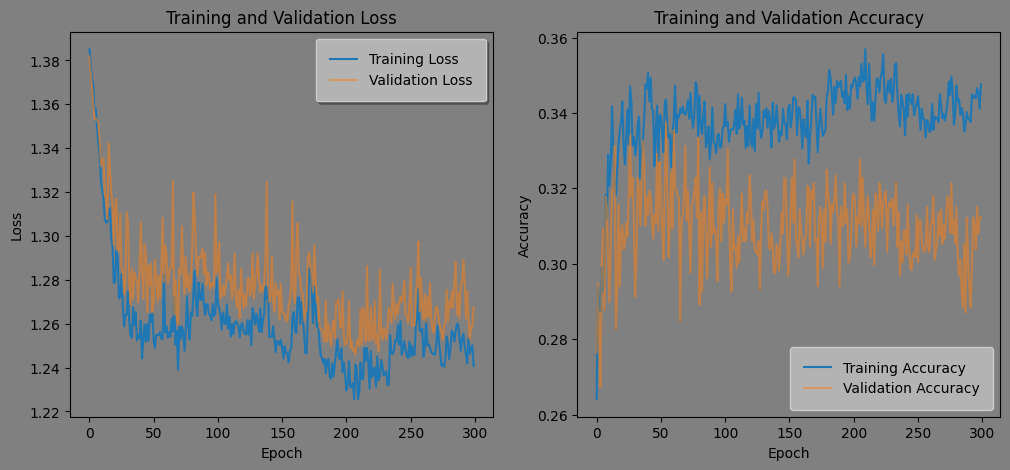

Total correct predictions: 1950/5699
Overall accuracy: 0.3422
Correct predictions for cat: 162/1426; Accuracy: 0.1136
Correct predictions for dog: 1051/1428; Accuracy: 0.7360
Correct predictions for rabbit: 323/1426; Accuracy: 0.2265
Correct predictions for control: 414/1419; Accuracy: 0.2918


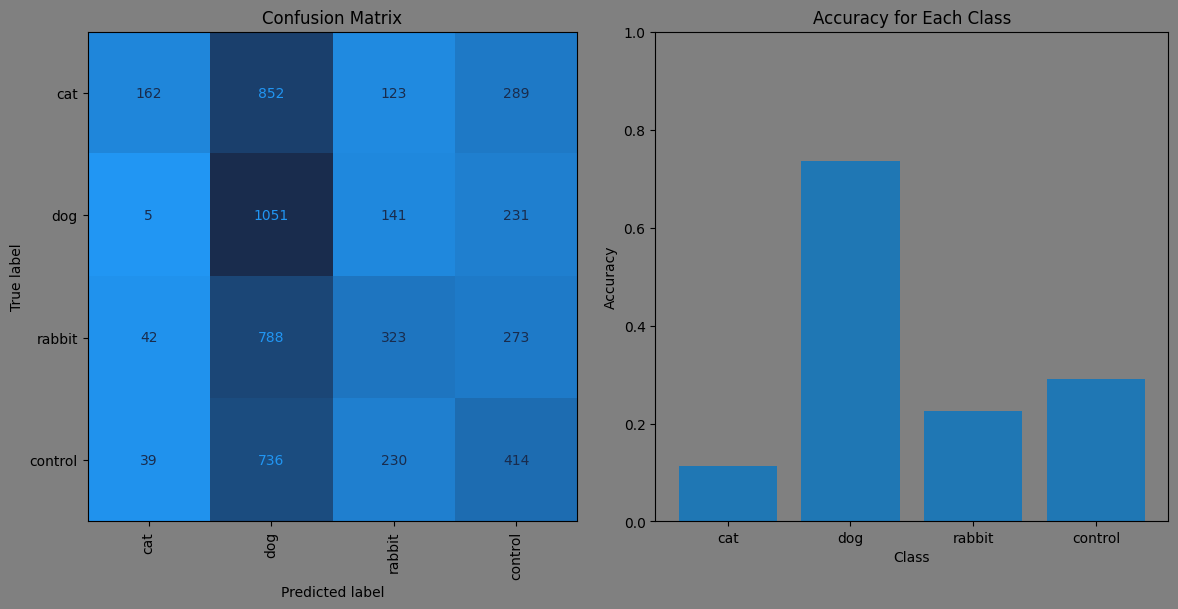

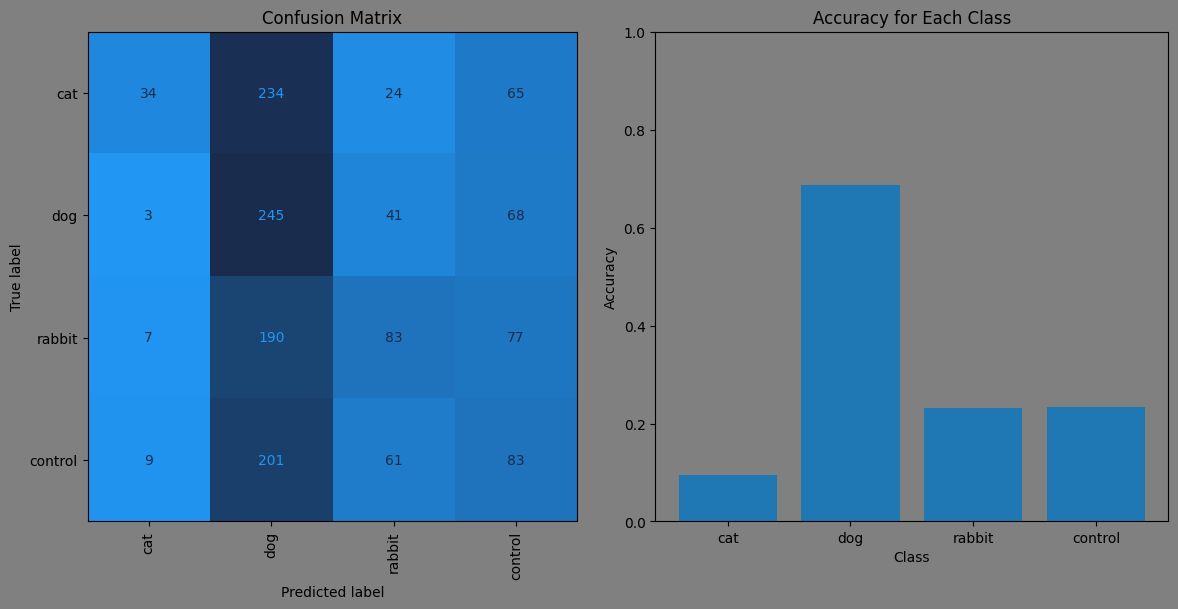

------------------- EEGSuperConv -------------------
Epoch [1/300], Train Loss: 41.3185, Train Accuracy: 0.2611, Validation Loss: 24.9210, Validation Accuracy: 0.2533
Epoch [51/300], Train Loss: 1.0561, Train Accuracy: 0.4820, Validation Loss: 1.0337, Validation Accuracy: 0.4800
Epoch [101/300], Train Loss: 0.8629, Train Accuracy: 0.5891, Validation Loss: 0.8676, Validation Accuracy: 0.5796
Epoch [151/300], Train Loss: 0.7396, Train Accuracy: 0.6468, Validation Loss: 0.7488, Validation Accuracy: 0.6365
Epoch [201/300], Train Loss: 0.6955, Train Accuracy: 0.6727, Validation Loss: 0.7480, Validation Accuracy: 0.6414
Epoch [251/300], Train Loss: 0.6187, Train Accuracy: 0.7031, Validation Loss: 0.7636, Validation Accuracy: 0.6491
Epoch [300/300], Train Loss: 0.6411, Train Accuracy: 0.6985, Validation Loss: 0.6196, Validation Accuracy: 0.7039


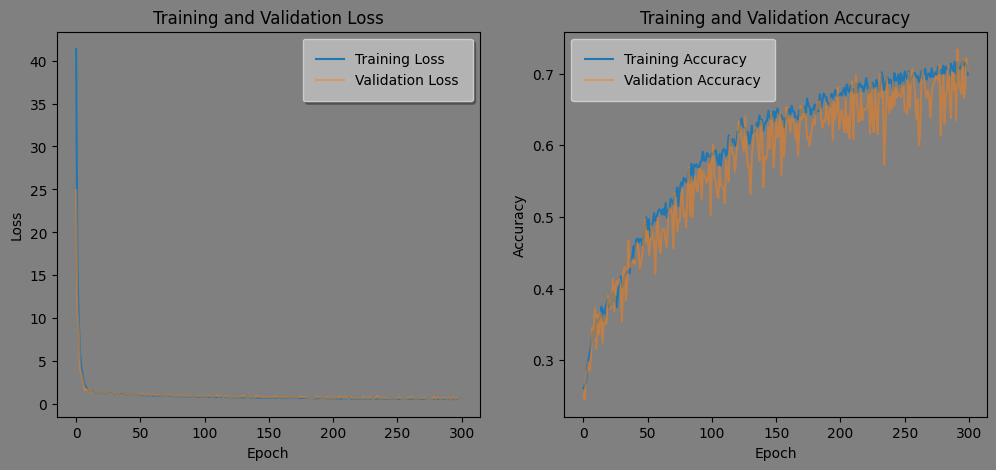

Total correct predictions: 4153/5699
Overall accuracy: 0.7287
Correct predictions for cat: 1289/1426; Accuracy: 0.9039
Correct predictions for dog: 925/1428; Accuracy: 0.6478
Correct predictions for rabbit: 986/1426; Accuracy: 0.6914
Correct predictions for control: 953/1419; Accuracy: 0.6716


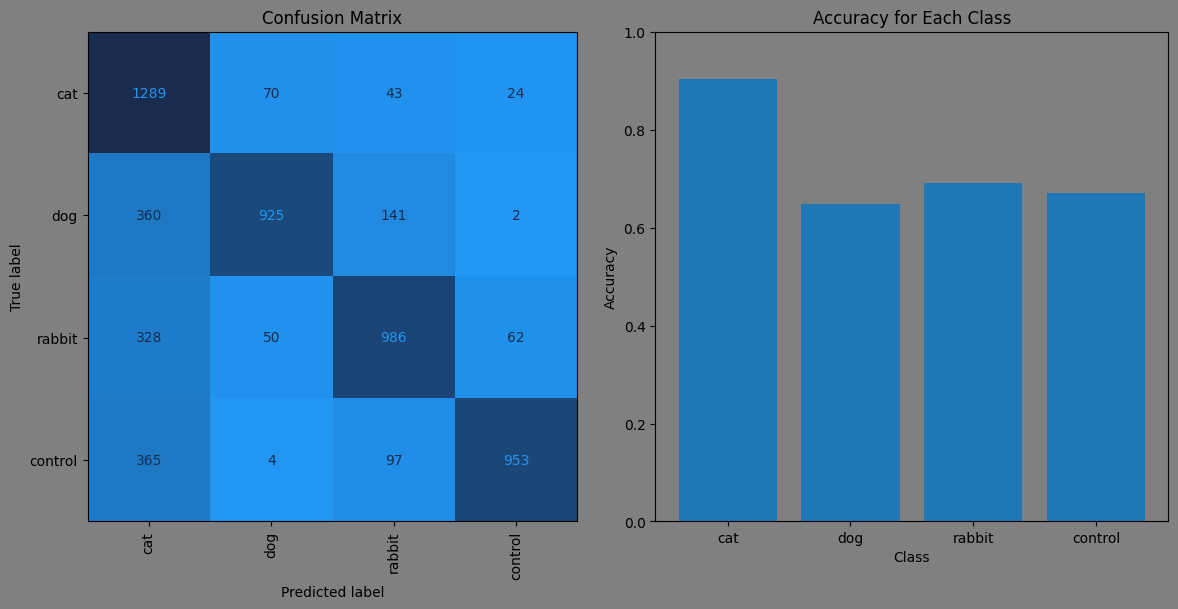

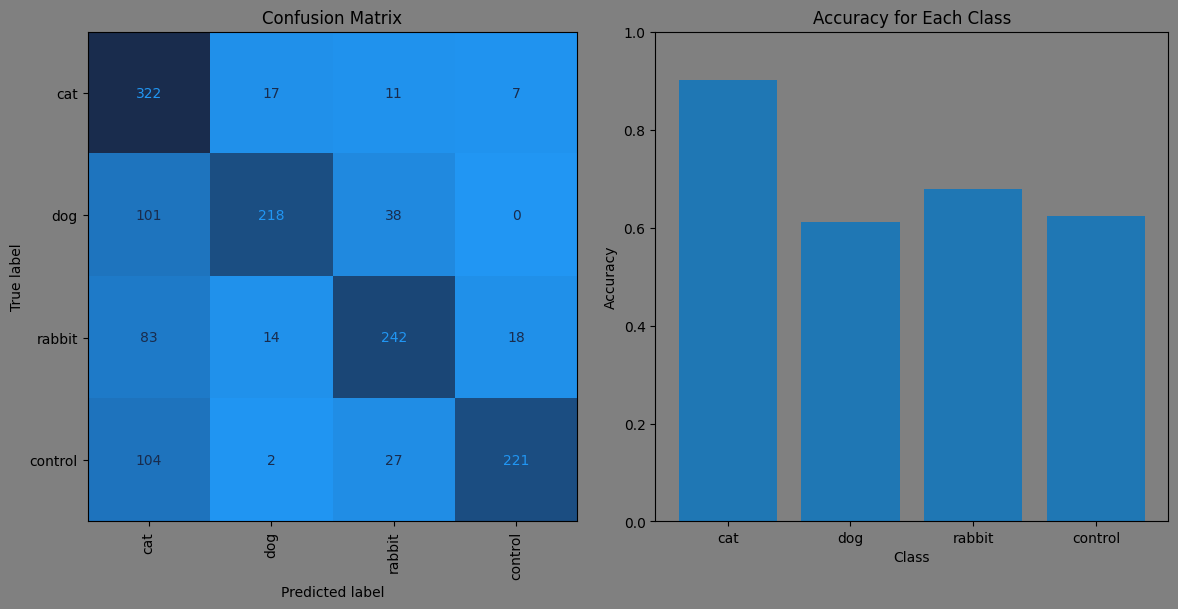

In [25]:

print ("------------------- LSTM_CNN_Model -------------------")
# Training loop for lstm_cnn_model
lstm_cnn_model = LSTM_CNN_Model(hidden_size=64,
                                    num_layers=1,
                                    num_classes=4,
                                    input_channels=16,
                                    kernel_size=3).to(device)
optimizer = optim.Adam(lstm_cnn_model.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(lstm_cnn_model,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(lstm_cnn_model, full_train_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(lstm_cnn_model, full_val_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys(), 
                       print_metrics=False)

print ("------------------- EEGLstmConv -------------------")
# Training loop for eeglstmconv
eeglstmconv = EEGLstmConv(num_channels=16, hidden_size=50, num_classes=4).to(device)
optimizer = optim.Adam(eeglstmconv.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eeglstmconv,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(eeglstmconv, full_train_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(eeglstmconv, full_val_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys(), 
                       print_metrics=False)


print ("------------------- EEGSuperConv -------------------")
# Training loop for eegsuperconv
eegsuperconv = EEGSuperConv(num_channels=16, num_classes=4).to(device)
optimizer = optim.Adam(eegsuperconv.parameters(), lr=lr)
full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies = train_model(eegsuperconv,
                                                                                            full_train_dataloader,
                                                                                            full_val_dataloader,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            device,
                                                                                            num_epochs=epochs,
                                                                                            patience=patience,
                                                                                            verbose=verbose)
plot_loss_accuracy(full_train_losses, full_train_accuracies, full_val_losses, full_val_accuracies)
# Evaluate the model
evaluate_class_metrics(eegsuperconv, full_train_dataloader, device, 
                       class_names=full_eeg_dataset.class_mapping.keys())
evaluate_class_metrics(eegsuperconv, full_val_dataloader, device,
                          class_names=full_eeg_dataset.class_mapping.keys(), 
                          print_metrics=False)


